In [1]:
# -*- coding: utf-8 -*-
#  File: otus_pro_hw2_sklearn.ipynb
#  Project: 'OTUS PRO Homework #2'
#  Created by Gennady Matveev (gm@og.ly) on 08-01-2022.
#  Attributions: Silhuette_score calculation and plotting
#  adapted in part from sklearn documentation; KMeans part
#  borrows from webinar #8 Otus.ML.Pro

![OTUS.ML.Pro](https://docs.google.com/uc?export=download&id=1M2pwirq1BELoYSAbgbP2RvGuTf7giKbV)

# **$Homework$** **$2$**  
**OTUS Machine Learning Professional**

Goals:   
- Apply k-means, hierarhical и DBSCAN clustering methods to "German Credit Risk" dataset
- Find optimal number of clusters with Elbow method and Silhouette plot
- Try feature space compression with PCA, UMAP and tSNE, visualize data in 2D
- Interpret results: cluster means etc.
- Find differences in clusters with boxplots of features

Additional goals:  
- Explore other clustering models (GMM)
- And other metrics (David-Bouldin score and Bayes information criteria)
- Have a look at 3d possibilities of TSNE and UMAP
- Come up with auxiliary measures of clustering quality
- Explore dependence of clustering outcomes of preprocessing methods

Means:  
- All meaningful programming will be done in sklearn and pandas
- ATOM library is used for preprocessing:  
https://tvdboom.github.io/ATOM/about/

Dataset:
- German Credit Risk 
https://www.kaggle.com/uciml/german-credit

Abbreviations:
- EDA: exploratory data analysis
- PP: preprocessing
- H/Ps: hyperparameters
- AC: agglomerative clustering
- GMM: Gaussian mixture model

<a href="https://colab.research.google.com/github/oort77/OTUS_PRO_HW2/blob/main/otus_pro_hw2_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

### Google colab specific part

Please uncomment and run the cell below to install dependencies.  
Typical runtime on colab is around 8 minutes (to include installation of libraries ~ 2-3 minutes).

In [2]:
#  !pip install -r 'https://drive.google.com/uc?export=download&id=1-iwFCNjPKyld9ArcAo8BcIngBnjlsaRW'

### Import libraries and setup notebook

In [3]:
import pandas as pd
import numpy as np
from atom import ATOMClassifier
from sklearn.cluster import AgglomerativeClustering, DBSCAN, \
    KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, \
    MinMaxScaler, FunctionTransformer, KBinsDiscretizer
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from umap import UMAP
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import pdist
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import plotly
from tqdm import tqdm
from time import sleep
import re
from IPython.core.display import display, HTML
import warnings

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


#### Miscellaneius settings 

In [4]:
%matplotlib inline
display(HTML("<style>.container {width:80% !important; }</style>"))
# %config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"]=(12,4)
sns.set(rc={'figure.figsize': (12, 4)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

#### ML parameters

In [5]:
random_state = 17
njobs = -1

### Load data

In [6]:
data = pd.read_csv("https://drive.google.com/uc?export=download&id=1Ab-pu0jfDDd9fwLDypziYmodD5k-bVpi",
                   compression="zip", index_col=0)
# Add dummy target column

data["Target"] = np.random.randint(2, size=data.shape[0])
data.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Target  
0         6             radio/TV       0  
1        48             radio/TV       0  
2        12            education       1  
3        42  furniture/equipment       1  
4        24                  car       1

### EDA

#### Basic

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Target            1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 85.9+ KB


In [8]:
data.describe().T

count      mean        std    min     25%     50%      75%  \
Age            1000.0    35.546    11.3755   19.0    27.0    33.0    42.00   
Job            1000.0     1.904     0.6536    0.0     2.0     2.0     2.00   
Credit amount  1000.0  3271.258  2822.7369  250.0  1365.5  2319.5  3972.25   
Duration       1000.0    20.903    12.0588    4.0    12.0    18.0    24.00   
Target         1000.0     0.515     0.5000    0.0     0.0     1.0     1.00   

                   max  
Age               75.0  
Job                3.0  
Credit amount  18424.0  
Duration          72.0  
Target             1.0

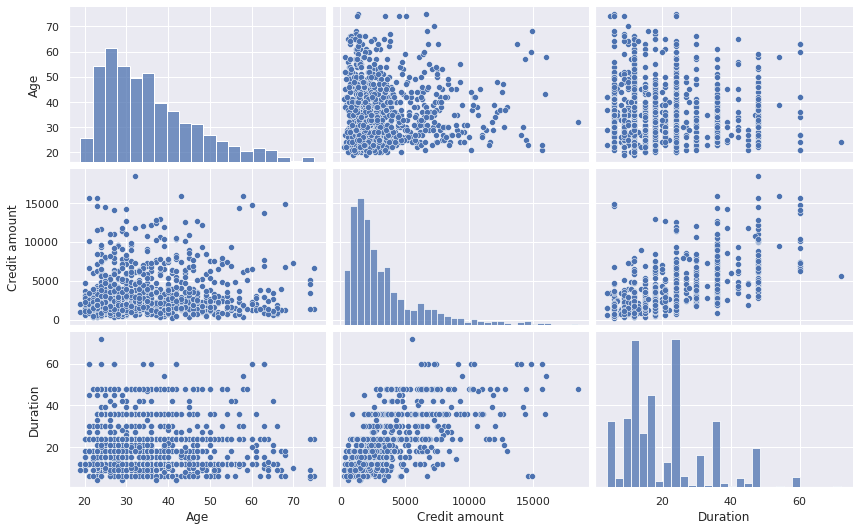

In [9]:
sns.pairplot(data, vars=["Age", "Credit amount",
             "Duration"], height=2.5, aspect=1.62)

#### Run profile report on the dataset

In [10]:
# data.profile_report()

### Preprocessing

####  Create an ATOM classifier instance (not going to classify, just use it for PP step

In [11]:
atom = ATOMClassifier(data, n_jobs=njobs, test_size=0.2,
                      verbose=1, warnings=False, random_state=random_state)

<< ================== ATOM ================== >>
Algorithm task: binary classification.
Parallel processing with 2 cores.

Dataset stats ==================== >>
Shape: (1000, 10)
Scaled: False
Missing values: 577 (5.8%)
Categorical features: 5 (55.6%)
Outlier values: 34 (0.4%)
-------------------------------------
Train set size: 800
Test set size: 200
-------------------------------------



####  Check if it's worth to log numerical features

In [12]:
# atom.distribution("Credit amount")
atom.distribution(columns="Credit amount")

ks  p_value
lognorm      0.0438   0.0420
pearson3     0.0637   0.0006
beta         0.0641   0.0005
expon        0.1116   0.0000
norm         0.1648   0.0000
invgauss     0.2611   0.0000
triang       0.3903   0.0000
uniform      0.5572   0.0000
weibull_min  0.8109   0.0000
weibull_max  0.8583   0.0000
gamma        0.9990   0.0000

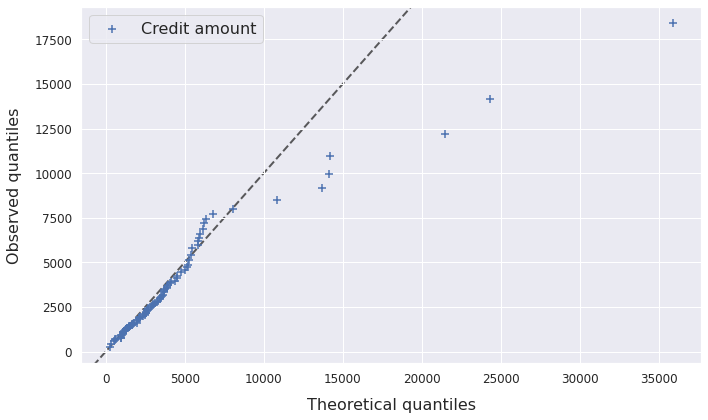

In [13]:
atom.plot_qq("Credit amount", distribution="lognorm")

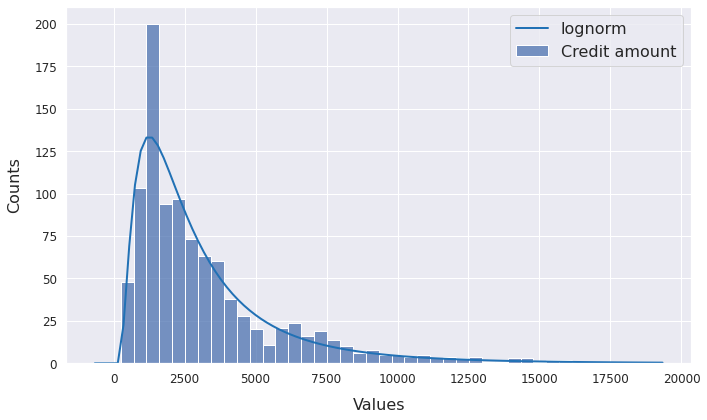

In [14]:
atom.plot_distribution("Credit amount", distribution="lognorm")

Define transfoms that may prove to be useful (or not)

In [15]:
from sklearn.compose import ColumnTransformer, make_column_transformer 
def log_transform(x):
    return np.log1p(x)


log_cols = ["Credit amount"] #"Age", "Duration"
log_transformer = FunctionTransformer(log_transform)
log1pt = make_column_transformer((log_transformer, log_cols), #["Credit amount"]
                          remainder='passthrough')
# ColumnTransformer(
# ...     [("norm1", Normalizer(norm='l1'), [0, 1]),
# ...      ("norm2", Normalizer(norm='l1'), slice(2, 4))])
kb = KBinsDiscretizer(n_bins=10, encode="onehot", strategy="quantile")

#### PP sequence

Choice of preprocessing steps strongly affects clustering results. Feel free to play.

In [16]:
atom.X.describe().T
atom.X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [17]:
# atom.apply(log_transform, columns=["Credit amount"])
atom.impute(strat_cat="unknown")
# atom.clean(drop_min_cardinality=False)
atom.encode()  # frac_to_other=0.05)
atom.add(log1pt)#, columns="Credit amount")
# atom.apply(lambda x: np.log1p(x), columns="Credit amount")
# atom.add(kb, columns = log_cols)
atom.add(StandardScaler())
# atom.add(MinMaxScaler())
atom.gauss()
# atom.add(kb, columns = log_cols)

Fitting Imputer...
Imputing missing values...
Fitting Encoder...
Encoding categorical columns...
Fitting ColumnTransformer...
Applying ColumnTransformer to the dataset...
Fitting StandardScaler...
Applying StandardScaler to the dataset...
Making features Gaussian-like...


#### Have a look at the transformed dataset's profile

In [18]:
# atom.X.profile_report()

#### Transformed dataset

In [19]:
X = atom.X
X.head()

Age     Sex     Job  Housing_own  Housing_rent  Housing_free  \
0  0.1730  0.6439 -0.6722       0.0709         0.643       -0.4764   
1 -0.7729 -0.6239 -0.6722       0.0709         0.643       -0.4764   
2 -0.3894 -1.2236 -0.6722      -1.3357         0.643       -0.4764   
3  0.6470 -1.3865 -0.6722       0.0709         0.643       -0.4764   
4 -1.2042  0.2138 -0.6722       0.0709         0.643       -0.4764   

   Saving accounts_quite rich  Saving accounts_moderate  \
0                     -0.3471                    3.8730   
1                     -0.3471                   -0.2582   
2                     -0.3471                   -0.2582   
3                     -0.3471                   -0.2582   
4                     -0.3471                   -0.2582   

   Saving accounts_little  Saving accounts_unknown  Saving accounts_rich  \
0                 -0.3448                  -1.2058               -0.4863   
1                  2.9003                  -1.2058               -0.4863   
2                 -0.3448                   0.8293               -0.4863   
3                 -0.3448                   0.8293               -0.4863   
4                 -0.3448                  -1.2058                2.0564   

   Checking account_unknown  Checking account_rich  Checking account_little  \
0                   -0.2233                 1.2344                  -0.2717   
1                   -0.2233                -0.8101                   3.6804   
2                   -0.2233                -0.8101                  -0.2717   
3                   -0.2233                -0.8101                   3.6804   
4                   -0.2233                 1.2344                  -0.2717   

   Checking account_moderate  Credit amount  Duration  Purpose_radio/TV  \
0                    -0.6217         -0.587    0.3562            1.6186   
1                    -0.6217         -0.587   -1.6817           -0.6178   
2                     1.6086         -0.587    0.5199           -0.6178   
3                    -0.6217         -0.587    1.2646            1.6186   
4                    -0.6217         -0.587   -0.7699            1.6186   

   Purpose_car  Purpose_furniture/equipment  Purpose_business  \
0      -0.7197                      -0.4725           -0.3216   
1       1.3894                      -0.4725           -0.3216   
2      -0.7197                       2.1165           -0.3216   
3      -0.7197                      -0.4725           -0.3216   
4      -0.7197                      -0.4725           -0.3216   

   Purpose_education  Purpose_vacation/others  Purpose_domestic appliances  \
0            -0.2441                  -0.1125                      -0.1234   
1            -0.2441                  -0.1125                      -0.1234   
2            -0.2441                  -0.1125                      -0.1234   
3            -0.2441                  -0.1125                      -0.1234   
4            -0.2441                  -0.1125                      -0.1234   

   Purpose_repairs  
0          -0.1517  
1          -0.1517  
2          -0.1517  
3          -0.1517  
4          -0.1517

#### Distribution of distances in the dataset

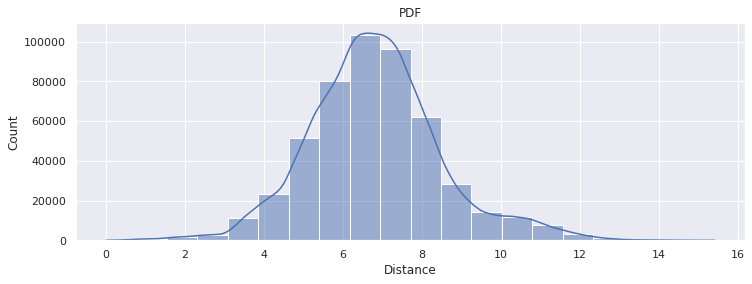

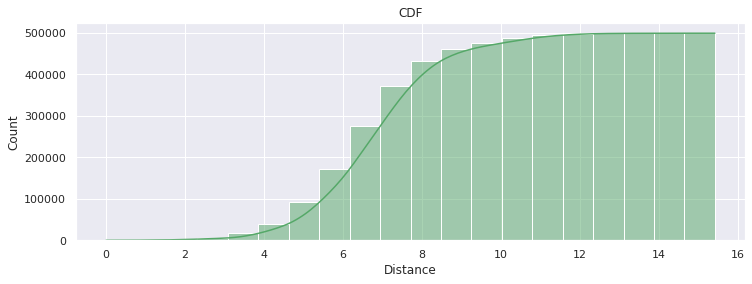

In [20]:
distr = pdist(X.values)
fig, ax = plt.subplots()
plt.setp(ax, xlabel="Distance")
plt.setp(ax, title="PDF")
_ = sns.histplot(data=distr, bins=20, kde=True)

fig, ax = plt.subplots()
plt.setp(ax, xlabel="Distance")
plt.setp(ax, title="CDF")
_ = sns.histplot(data=distr, bins=20, kde=True, cumulative=True, color="g")

### KMeans

#### Find the optimal number of clusters - Elbow method

In [21]:
from tqdm import tqdm
from time import sleep


def elbow_study(k_max: int = 20, model=KMeans):
    inertia = []
    with tqdm(total=(k_max-1)*10) as pbar:
        for k in range(1, k_max):
            clusterer = model(k, random_state=random_state)
            X_km = clusterer.fit(X)
            inertia.append(np.sqrt(X_km.inertia_))
            sleep(0.1)
            pbar.update(10)

    d = {}
    for k in range(2, k_max-1):
        i = k-1
        d[k] = (inertia[k-1]-inertia[k])/(inertia[k-2]-inertia[k-1])
    key_min = min(d.keys(), key=(lambda k: d[k]))

    plt.plot(range(1, k_max), inertia, marker="s")
    plt.title("The Elbow Method using Inertia")
    plt.xlabel("Number of clusters, k")
    plt.ylabel("Inertia")
    axes = plt.gca()
    y_min, y_max = axes.get_ylim()
    plt.vlines(key_min, y_min, y_max, colors="orange", linestyles="dashed")
    plt.show()

    plt.plot(range(2, k_max-1), [x for x in d.values()], marker="s")
    plt.title("The Elbow Method using Inertia")
    plt.xlabel("Number of clusters, k")
    plt.ylabel("Comparative decrease in inertia")
    plt.vlines(key_min, 0, 3, colors="g", linestyles="dashed")
    plt.hlines(d[key_min], 0, k_max, colors="r", linestyles="dashed")
    plt.show()

    print(f"Min Elbow score is {d[key_min]:.4f} for n_clusters = {key_min}")

100%|██████████| 190/190 [00:07<00:00, 24.59it/s]


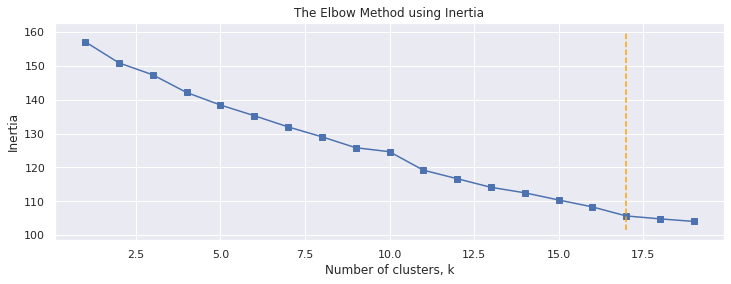

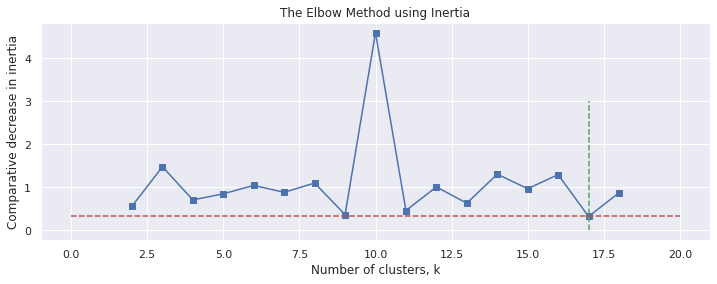

Min Elbow score is 0.3244 for n_clusters = 17


In [22]:
elbow_study()

We can see that the optimal number of clusters is 17.

####  Davies-Bouldin score for KMeans

Text(0.5, 1.0, 'Davies-Bouldin score vs. n_clusters')

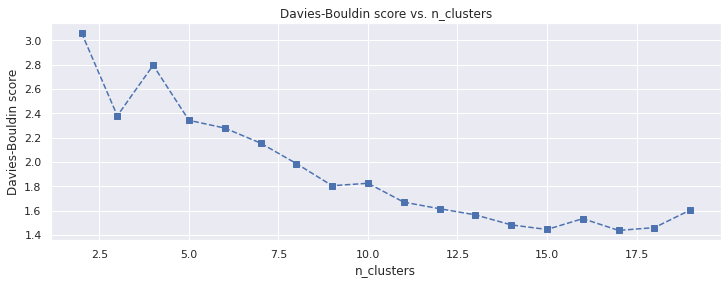

In [23]:
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score


def get_kmeans_score(data, center):
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    # Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    return score


scores = []
n_clusters = list(range(2, 20))
for n in n_clusters:
    scores.append(get_kmeans_score(X.values, n))

plt.plot(n_clusters, scores, linestyle='--', marker='s', color='b')
plt.xlabel("n_clusters")
plt.ylabel("Davies-Bouldin score")
plt.title("Davies-Bouldin score vs. n_clusters")

Davies-Bouldin criteria suggests 15 or even 17 clusters.

#### Find the optimal number of clusters - Silhuette plot

Parameters of clustering models:  

KMeans:  
- n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto'  

GaussianMixture:  
- n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans',   weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10  

DBSCAN:  
- eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None  

AgglomerativeClustering:  
- n_clusters=2, *, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False
 

In [24]:
def silhuette_study(model=KMeans, **p):
    range_iter = np.linspace(p["min"], p["max"], p["steps"])
    range_iter = [round(x, 1) for x in range_iter]
    scores = {}
    silhuette_min = {}
    with tqdm(total=p["steps"]*10) as pbar:
        for it in range_iter:
            fig, ax1 = plt.subplots()
            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(X) + (it + 1) * 10])
            if model == GaussianMixture:
                cluster_labels = model(
                    n_components=int(it), random_state=random_state).fit_predict(X)
                iter_name = "n_clusters"
            elif model == KMeans:
                cluster_labels = model(n_clusters=int(it),
                                       random_state=random_state).fit_predict(X)
                iter_name = "n_clusters"
            elif model == DBSCAN:
                cluster_labels = model(
                    eps=it, min_samples=pp["min_samples"]).fit_predict(X)
                iter_name = "eps"
            elif model == AgglomerativeClustering:
                # Iterate through number of H/Ps
                cluster_labels = AgglomerativeClustering(n_clusters=int(
                    it), linkage=pp["linkage"]).fit_predict(X.values)
                iter_name = "n_clusters"
#             print(cluster_labels.size)
            _, labels_count = np.unique(cluster_labels, return_counts=True)
            if len(labels_count) >= 2:
                silhouette_avg = silhouette_score(X.values, cluster_labels)
                scores[it] = silhouette_avg
                # Compute the silhouette scores for each sample
                sample_silhouette_values = silhouette_samples(
                    X, cluster_labels)
                y_lower = 10
                silhuette_min[it] = 1

                for i, _ in enumerate(range_iter):
                    # Aggregate the silhouette scores for samples belonging to
                    # cluster i, and sort them
                    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
                    ith_cluster_silhouette_values.sort()
                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i
                    color = cm.nipy_spectral(float(i) / it)
                    ax1.fill_betweenx(
                        np.arange(y_lower, y_upper),
                        0,
                        ith_cluster_silhouette_values,
                        facecolor=color,
                        edgecolor=color,
                        alpha=0.7,
                    )
                    y_lower = y_upper + 10  # 10 for the 0 samples
                    # Find min value of Silhuette score in iteration
                    if len(ith_cluster_silhouette_values) > 1 and \
                            min(ith_cluster_silhouette_values) < silhuette_min[it]:
                        silhuette_min[i] = min(
                            ith_cluster_silhouette_values)
                ax1.set_title(f"Silhouette plot for {iter_name} = {it}")
                ax1.set_xlabel("Silhouette coefficient values")
                ax1.set_ylabel("Cluster label")
                # The vertical line for average silhouette score of all values
                ax1.axvline(x=silhouette_avg, color="red", linestyle="dashed")
                ax1.text(0.805, 40, f"Score = {silhouette_avg:.4f}")
                # Clear the yaxis ticks
                ax1.set_yticks([])
                ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
                sleep(0.1)
                pbar.update(10)
    plt.show()

    # Best silhouette_avg
    key_max = max(scores.keys(), key=(lambda k: scores[k]))
    print(
        f"Max silhuette score is {scores[key_max]:.4f} for {iter_name} = {key_max:.1f}\n")
    print("""Let's find the number of clusters with max value of min Silhuette score,  
    i.e. with minimum overlap.\n""")
    best_keys = sorted(silhuette_min, key=silhuette_min.get, reverse=True)[:3]
    # Set apart the first max
    best_key = best_keys[1]
    _, ax = plt.subplots()
    lists = sorted(silhuette_min.items())
    x, y = zip(*lists)
    x = [int(w) for w in x]
    plt.plot(x, y)
#     plt.axvline(best_key, c="g", linestyle="--")
#     plt.axhline(silhuette_min[best_key], c="r", linestyle="--")
    ax.set_xlim([0, p["max"]+1])
    plt.suptitle(
        f"Min values of Silhuette score for {iter_name}\n(the higher the better)")
    _ = plt.show()
    print(f"Best keys with max values of min silhuette scores : {best_keys}")
    silh_scores = pd.DataFrame.from_dict(scores, orient='index',
                                         columns=["Silhuette score"])
    silh_scores.rename_axis(index=iter_name, inplace=True)
    silh_scores_nice = silh_scores.T.style.highlight_max(
        props='color:orange', axis=1)

    return(silh_scores_nice)

#### Run  Silhuette study with KMeans

100%|██████████| 190/190 [00:09<00:00, 20.38it/s]


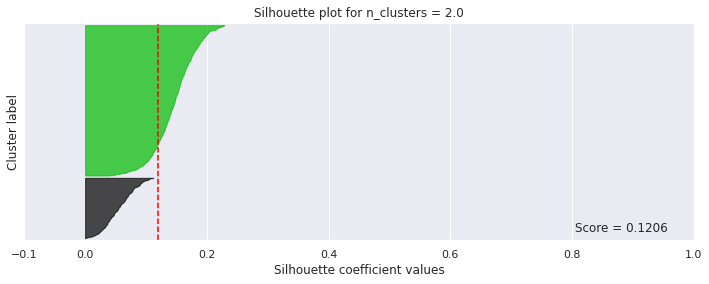

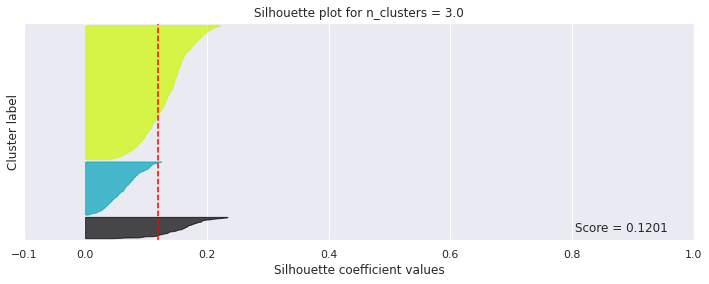

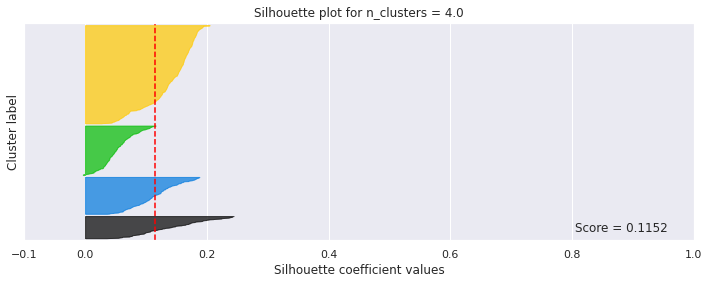

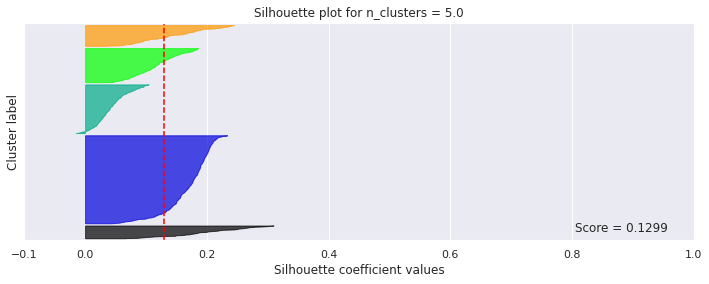

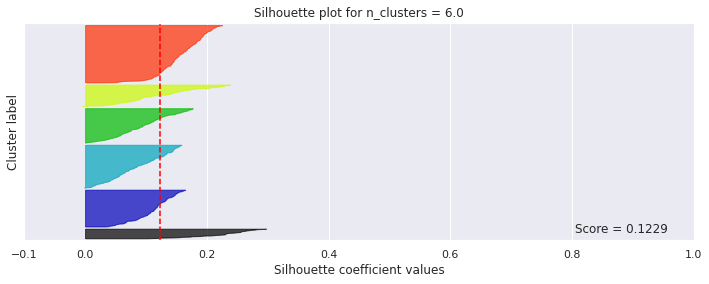

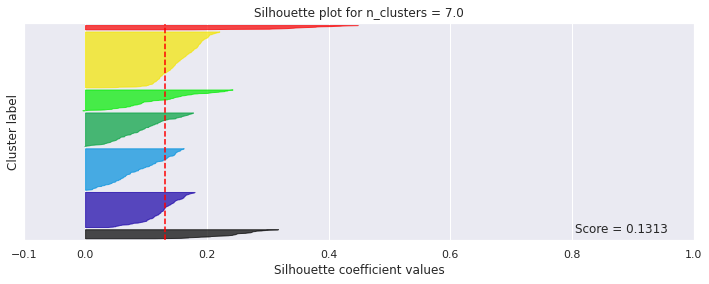

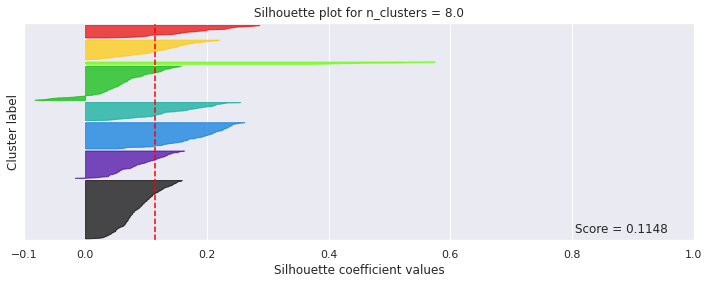

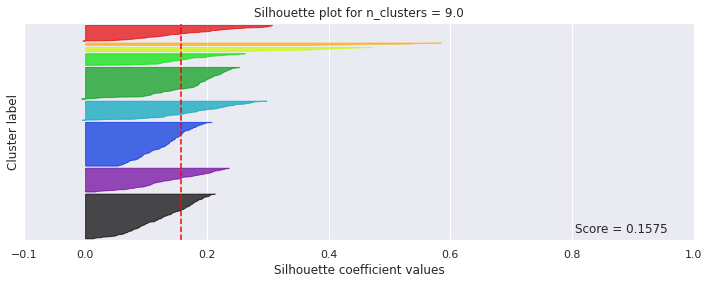

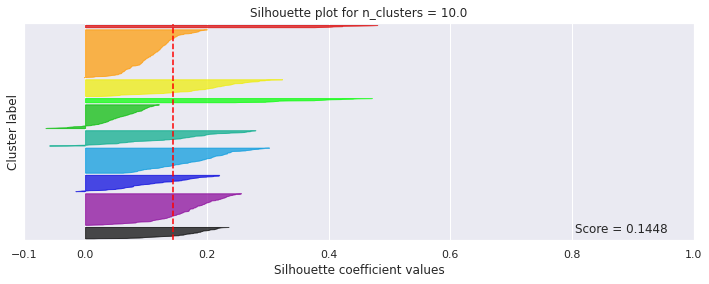

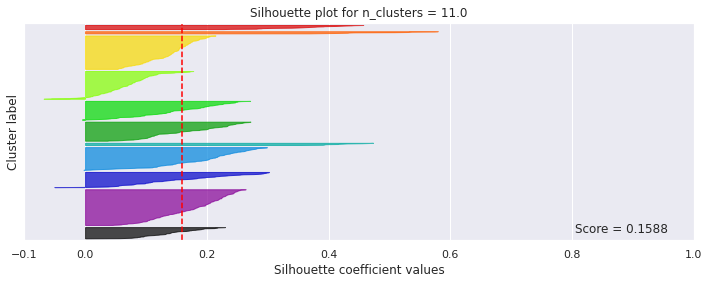

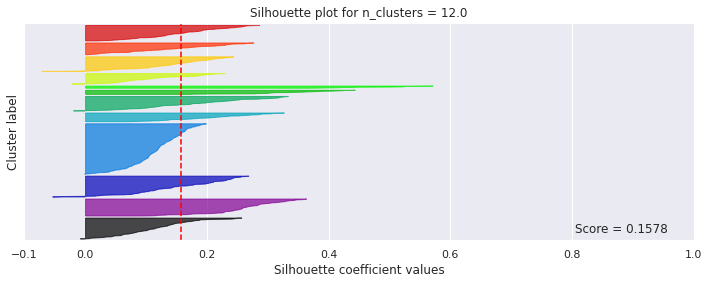

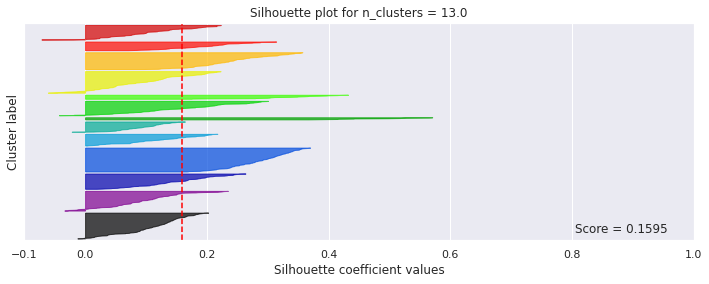

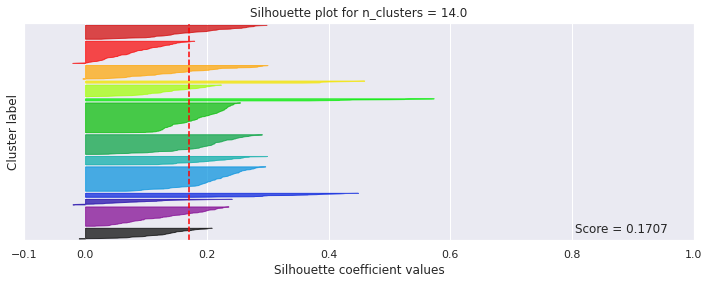

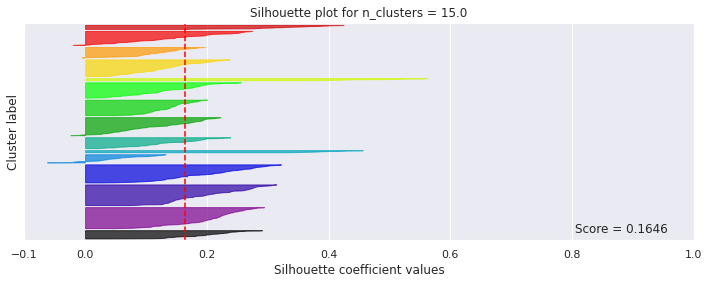

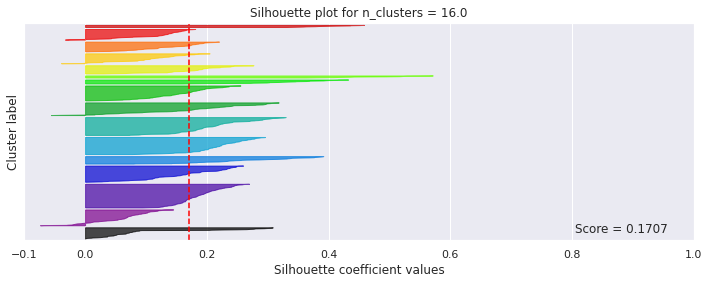

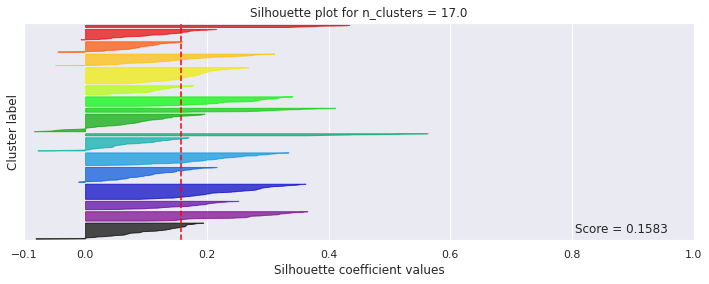

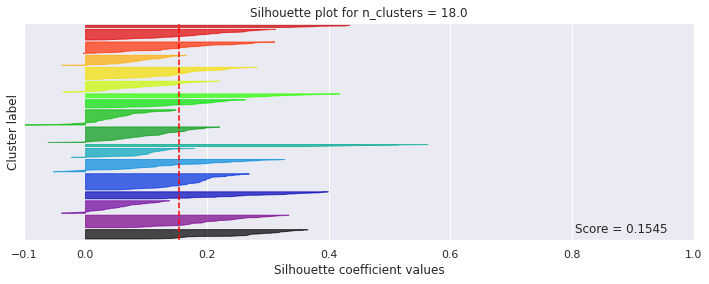

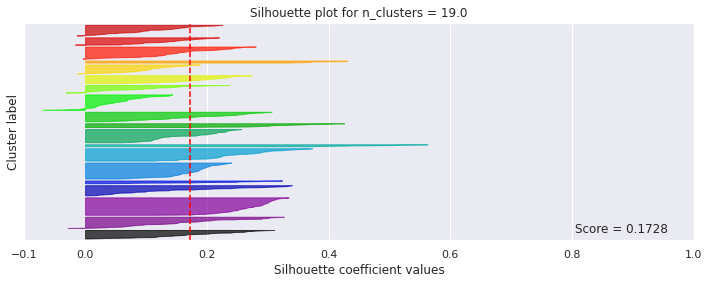

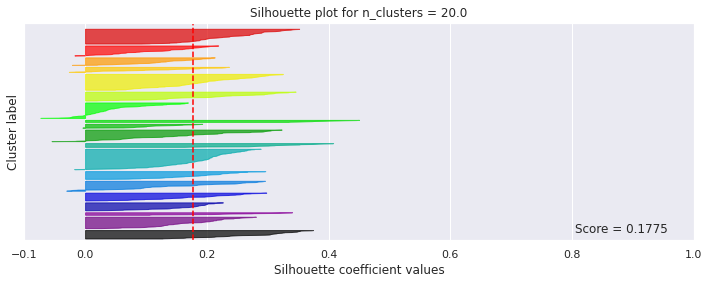

Max silhuette score is 0.1775 for n_clusters = 20.0

Let's find the number of clusters with max value of min Silhuette score,  
    i.e. with minimum overlap.



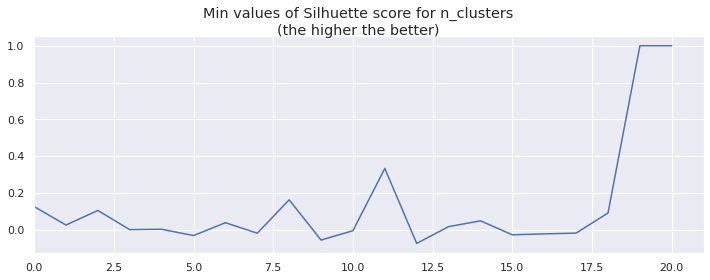

Best keys with max values of min silhuette scores : [19.0, 20.0, 11.0]


In [25]:
pp = {"min": 2, "max": 20, "steps": 19}
silhuette_scores = silhuette_study(model=KMeans, **pp)

In [26]:
silhuette_scores

The silhuette score is the highest for n_clusters=20 with negative values of Silhoutte score.

So far we have:  
* Elbow -           17 clusters  
* David-Bouldin -   17 clusters  
* Silhuette -      20 clusters  

### GMM

#### Run  Silhuette study with Gaussian mixture

100%|██████████| 190/190 [00:06<00:00, 27.71it/s]


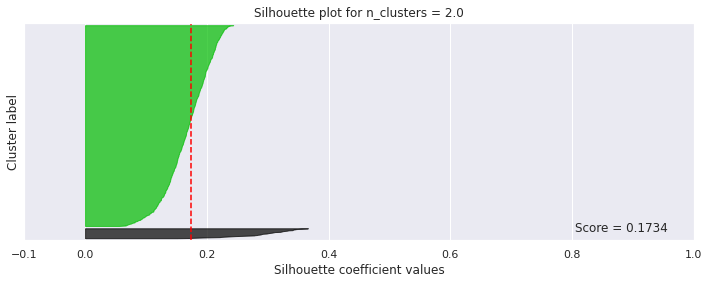

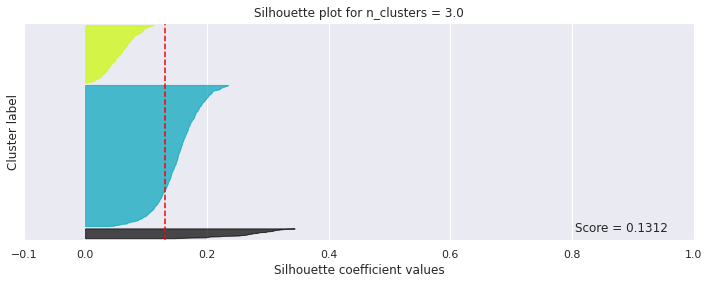

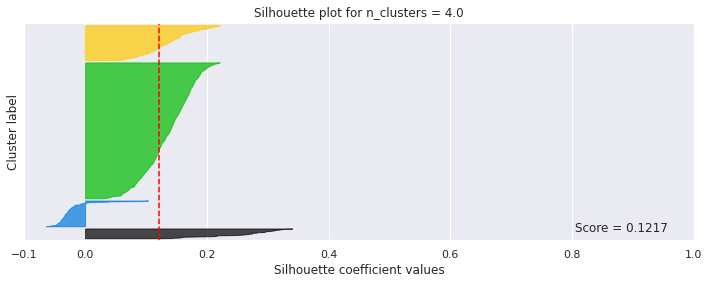

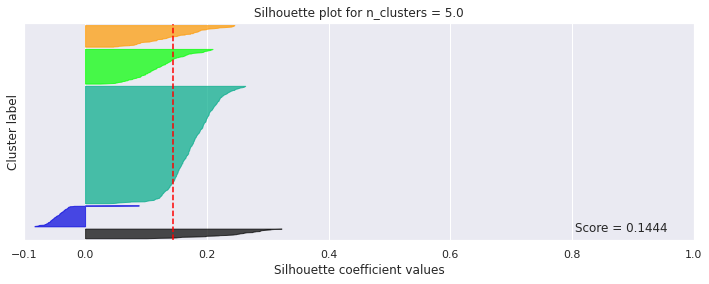

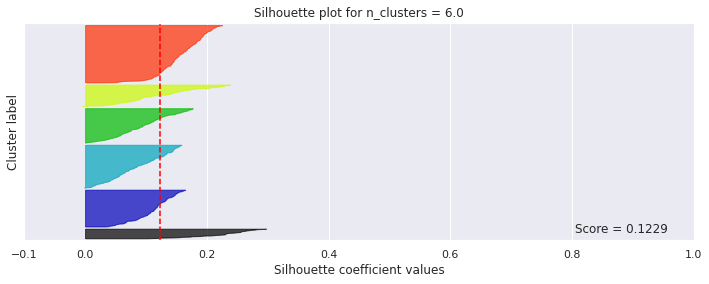

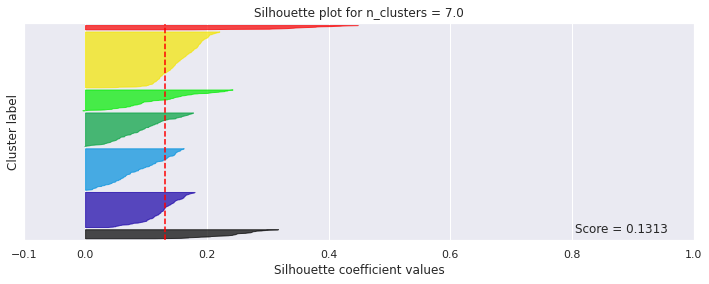

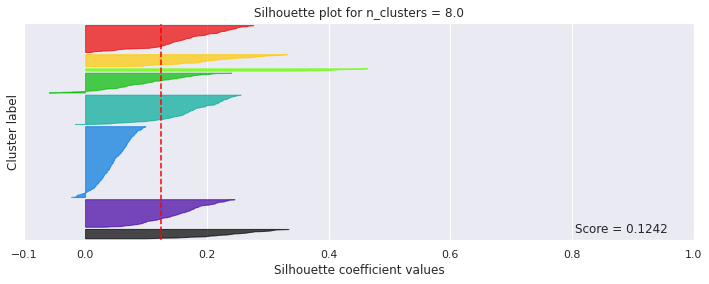

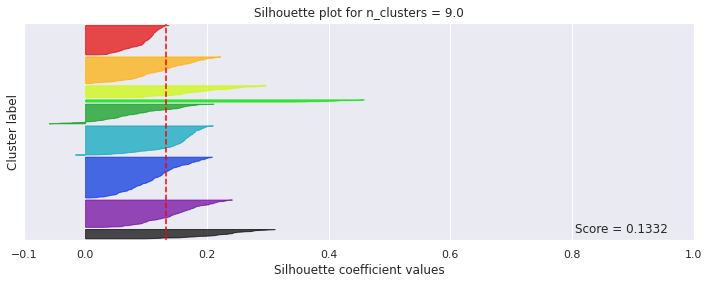

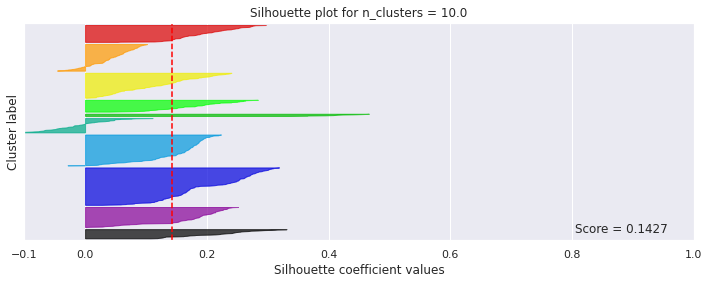

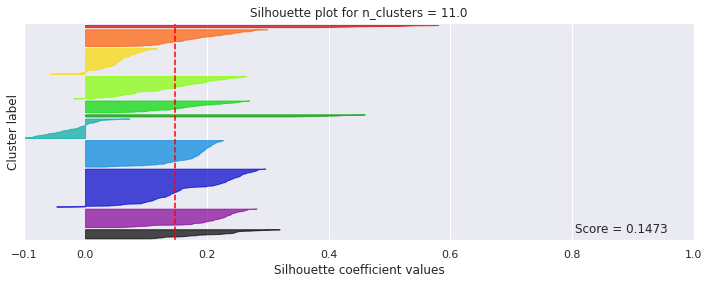

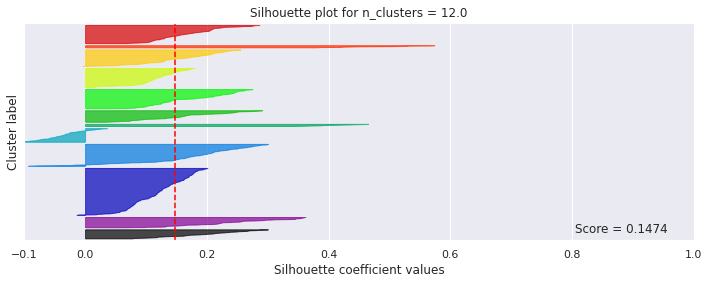

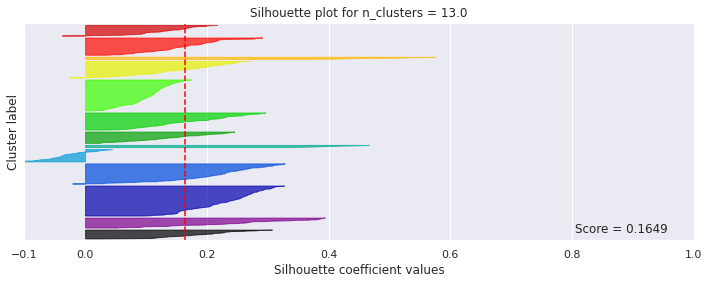

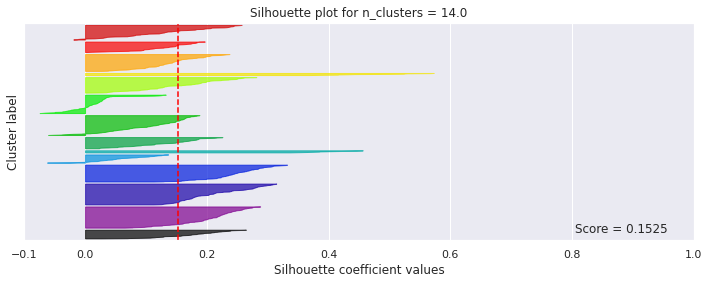

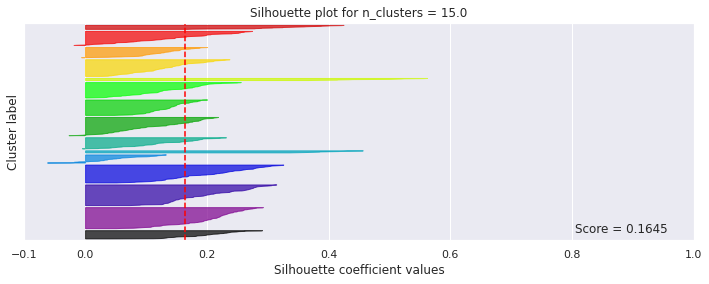

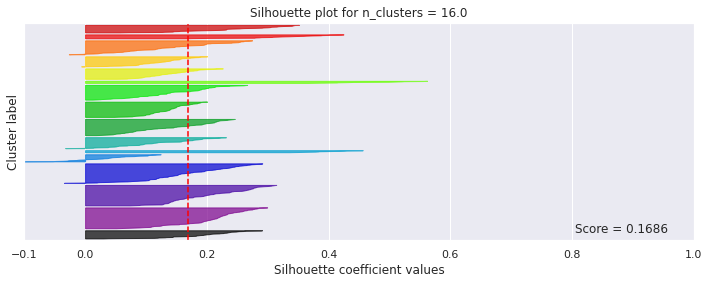

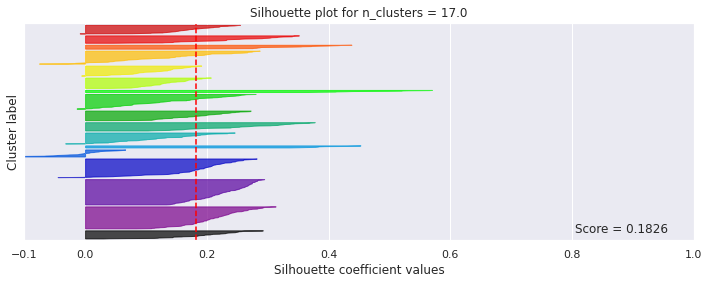

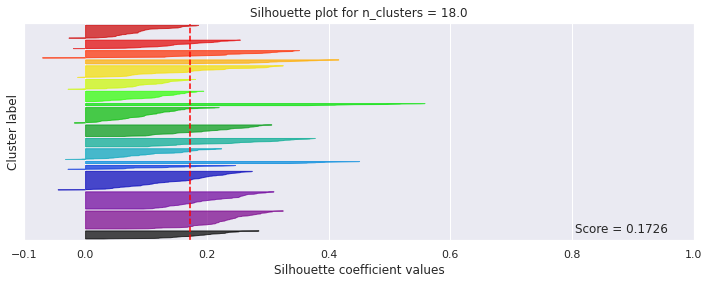

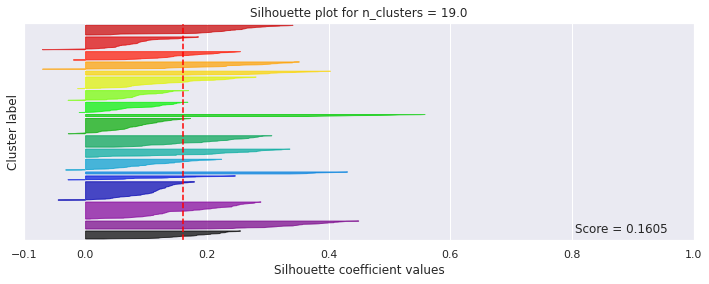

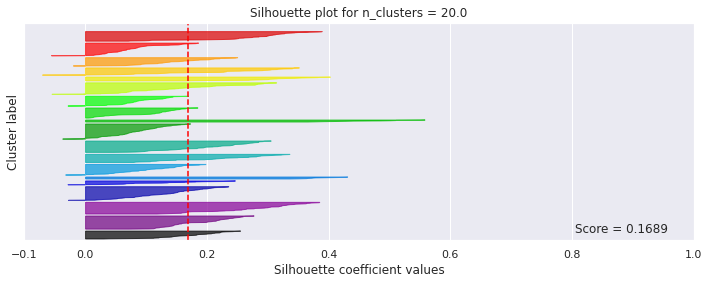

Max silhuette score is 0.1826 for n_clusters = 17.0

Let's find the number of clusters with max value of min Silhuette score,  
    i.e. with minimum overlap.



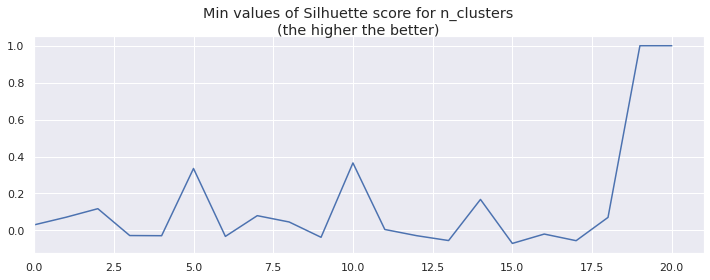

Best keys with max values of min silhuette scores : [19.0, 20.0, 10.0]


In [27]:
pp = {"min": 2, "max": 20, "steps": 19}
silhuette_study(model=GaussianMixture, **pp)

Silhuette method suggests 17 clusters. We notice that in this case the majority of scores are positive, suggesting small overalapping of clusters.

#### Bayesian Information Criterion (BIC) for GMM

In [28]:
n_components = range(2, 20)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score = []
for cov in covariance_type:
    for n_comp in n_components:
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov)
        gmm.fit(X.values)
        score.append((cov, n_comp, gmm.bic(X.values)))
scores = pd.DataFrame.from_records(score)
scores.columns = ["Covariance type", "n_clusters", "score"]
scores["score"] = scores["score"].apply(lambda x: int(round(x, -2)))
# by, axis=0, ascending=True, inplace=False
scores.sort_values(by="score", axis=0, inplace=True)
scores[:19].T

53       70       71       68       69       48      52  \
Covariance type     diag     full     full     full     full     diag    diag   
n_clusters            19       18       19       16       17       14      18   
score            -117000  -112300  -104900  -104900  -103200  -102100  -99800   

                     67      50      65      51      66      49      64  \
Covariance type    full    diag    full    diag    full    diag    full   
n_clusters           15      16      13      17      14      15      12   
score            -99100  -98400  -98200  -98200  -97300  -93600  -93500   

                     63      47      46      62      60  
Covariance type    full    diag    diag    full    full  
n_clusters           11      13      12      10       8  
score            -89600  -86900  -86500  -85200  -76700

The lower the BIC score, the better is the model. The number of choice is 19.  
Thus, for GMM we have:  
* Silhuette - 17 clusters  
* BIC - 19 clusters

### DBSCAN

#### Run  DBSCAN on an eps, min_samples grid

In [29]:
clusters = pd.DataFrame()
max_length = 1
eps_range = np.linspace(2.0, 8.0, 13)
min_samples_range = range(10, 45, 5)
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_samples_range):
        k = i*len(min_samples_range) + j
        clustering = DBSCAN(eps=eps, min_samples=min_samples,
                            n_jobs=njobs).fit(X.values)
        labels = clustering.labels_
        unique, counts = np.unique(labels, return_counts=True)
        if len(unique) > max_length:
            max_length = len(unique)
        clusters = pd.concat([clusters, pd.Series(counts)],
                             axis=1)
clusters = clusters.fillna(0).astype("int")
clusters.index = list(range(-1, max_length-1))
clusters.rename_axis(index=["cluster"], inplace=True)
clusters.columns = list(range(0, len(eps_range)*len(min_samples_range)))
clusters.rename(columns=lambda k: str(round(eps_range[k//len(min_samples_range)], 1))+", " + str(
    min_samples_range[k % len(min_samples_range)]), inplace=True)
clusters.rename_axis(columns=["eps, min_samples"], inplace=True)
clusters = clusters.applymap((lambda x: "" if x == 0 else x))
clusters = clusters.loc[:, clusters.loc[-1, :]
                        < X.shape[0]*0.1].sort_values(by=-1, axis=1)
counts = clusters.apply(lambda x: x.apply(type).value_counts()).iloc[1]
max_count = max(counts)

DBSCAN results are sorted by '-1' cluster that represents outliers. Presumably, we need to find a reasonable  
compromise between the number of outliers and the number of clusters. Let's leave only the results with less  
than 10% outliers.

In [30]:
clusters[:max_count]

eps, min_samples 6.5, 10 6.0, 10 8.0, 40 8.0, 30 8.0, 25 8.0, 20 8.0, 15  \
cluster                                                                    
-1                     1      13      24      24      24      24      24   
 0                   954     954     976     976     976     976     976   
 1                    12      12                                           
 2                    12      21                                           
 3                    21                                                   
 4                                                                         

eps, min_samples 7.5, 40 7.5, 35 7.5, 30 7.5, 25 7.5, 20 7.5, 15 7.0, 20  \
cluster                                                                    
-1                    24      24      24      24      24      24      24   
 0                   976     976     976     976     976     976     954   
 1                                                                    22   
 2                                                                         
 3                                                                         
 4                                                                         

eps, min_samples 7.0, 15 8.0, 35 6.5, 15 6.0, 15 6.5, 20 6.0, 20 5.5, 10  \
cluster                                                                    
-1                    24      24      25      26      26      27      29   
 0                   954     976     954     954     954     953     951   
 1                    22              21      20      20      20      20   
 2                                                                         
 3                                                                         
 4                                                                         

eps, min_samples 5.5, 15 5.0, 10 7.0, 30 5.0, 15 6.5, 25 6.5, 30 6.5, 35  \
cluster                                                                    
-1                    30      39      46      46      46      46      46   
 0                   951     901     954     898     954     954     954   
 1                    19      42              41                           
 2                            18              15                           
 3                                                                         
 4                                                                         

eps, min_samples 6.5, 40 7.0, 40 7.0, 35 7.0, 25 6.0, 25 6.0, 30 6.0, 40  \
cluster                                                                    
-1                    46      46      46      46      47      47      48   
 0                   954     954     954     954     953     953     952   
 1                                                                         
 2                                                                         
 3                                                                         
 4                                                                         

eps, min_samples 6.0, 35 5.5, 20 5.5, 25 5.5, 30 5.5, 35 5.5, 40 4.5, 10  \
cluster                                                                    
-1                    48      50      51      51      53      57      60   
 0                   952     950     949     949     947     943      50   
 1                                                                   789   
 2                                                                    38   
 3                                                                    46   
 4                                                                    17   

eps, min_samples 5.0, 20 5.0, 25 5.0, 30 4.5, 15  
cluster                                           
-1                    65      74      89      97  
 0                   896     891     880      46  
 1                    39      35      31     785  
 2                                            35  
 3                                      

#### DBSCAN: how to choose optimal H/P?

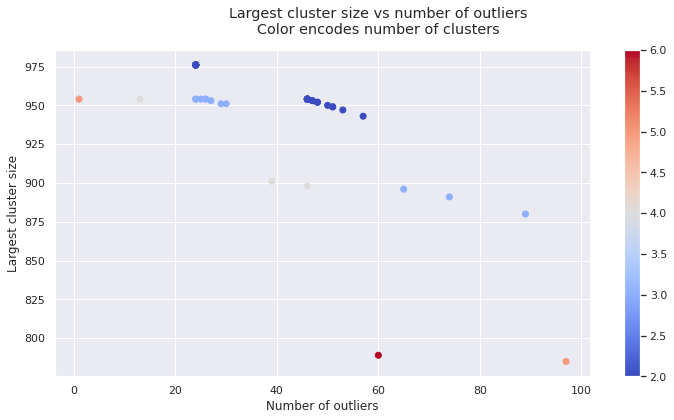

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
clusters = clusters.applymap((lambda x: 0 if x == "" else x))
max_clusters = clusters.apply("max")
# im = ax.scatter(clusters.loc[-1, :], clusters.loc[0, :],
im = ax.scatter(clusters.loc[-1, :], max_clusters,
                c=counts, cmap="coolwarm") #.astype(float)
fig.colorbar(im, ax=ax)
# plt.axhline(y=50, linestyle="--", c="blue")

ax.set_xlabel("Number of outliers")
ax.set_ylabel("Largest cluster size")
plt.suptitle(
    "Largest cluster size vs number of outliers\nColor encodes number of clusters")
plt.show()

The plot above shows that most DBSCAN predictions have just a few possible values of the largest cluster. 

#### Run Elbow study on DBSCAN

As inertia is a sensible measure only for spherical clusters, we have to use other metrics for **DBSCAN**.  

We will calculate the distance to the nearest n points for each point, and then sort and plot the results.  
Finding the position of **elbow** (or **knee** in DBSCAN-speak) will give us the best **eps**. 

**n_neighbours** is set to **min_samples**.

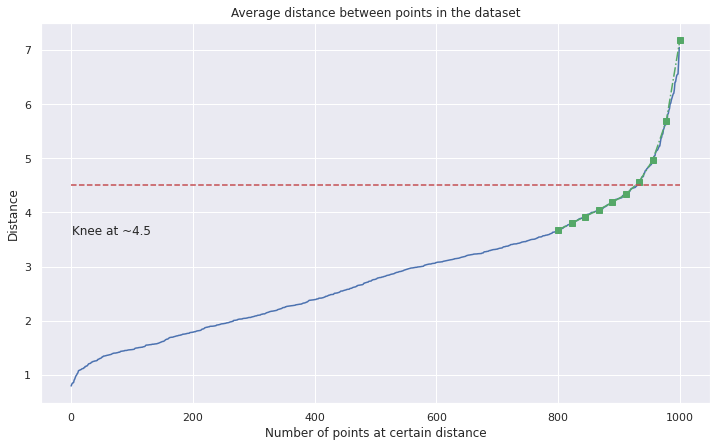

In [32]:
nnb = NearestNeighbors(n_neighbors=15)
nbrs = nnb.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.mean(distances, axis=1)
distances = np.sort(distances, axis=0)
fig, ax = plt.subplots(figsize=(12, 7))

# Piecewise linear approximation
p10 = np.poly1d(np.polyfit(list(range(1000)), distances, 100))
plt.plot(list(range(1000)), distances)
x = np.linspace(800, 1000, 10)
plt.plot(x, p10(x), linestyle='-.', marker='s', color='g')
ax.text(0.805, 3.6, "Knee at ~4.5")
plt.hlines(4.5, 0, 1000, colors="r", linestyles="dashed")

ax.set_xlabel("Number of points at certain distance")
ax.set_ylabel("Distance")
ax.set_title("Average distance between points in the dataset")
fig.show()

Plot kink is located at 4.5, we will explore **eps** around this value. 

#### Run Silhuette study on DBSCAN

100%|██████████| 130/130 [00:03<00:00, 37.54it/s]


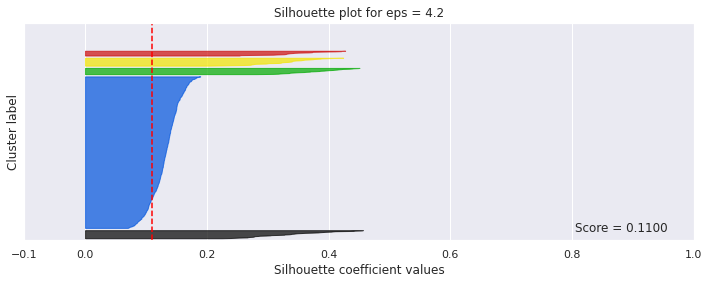

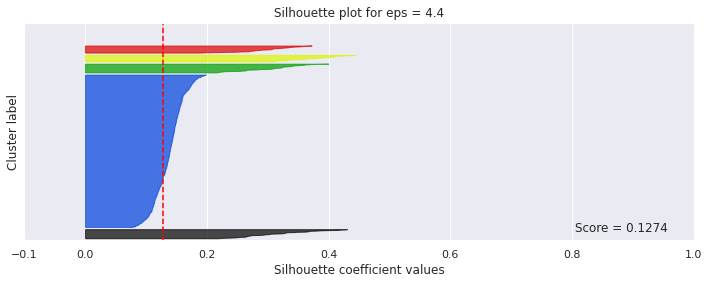

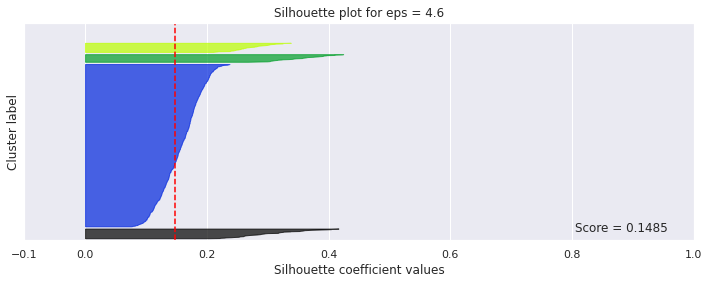

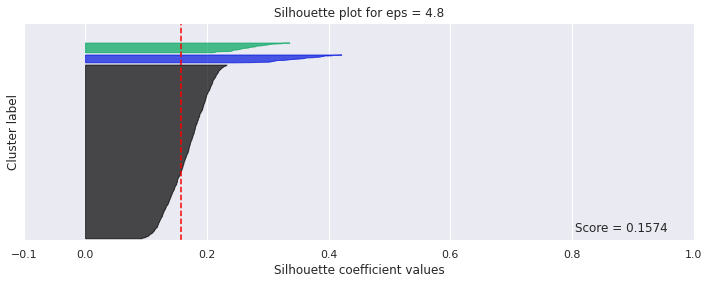

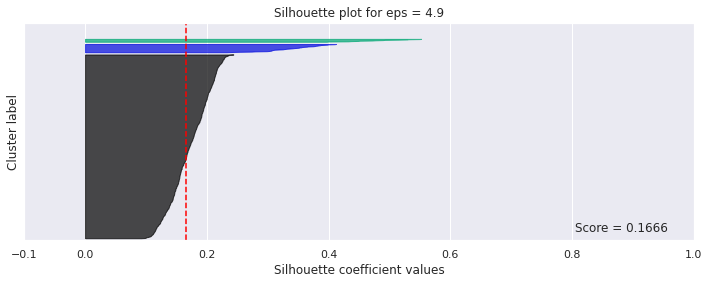

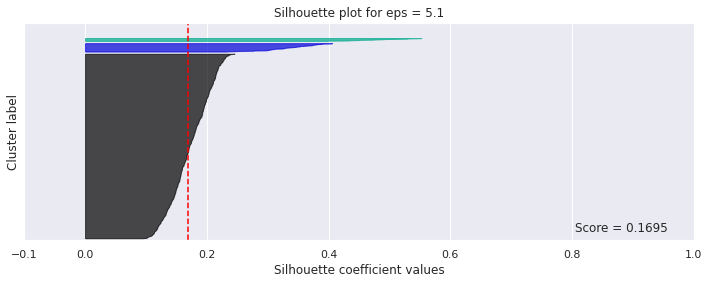

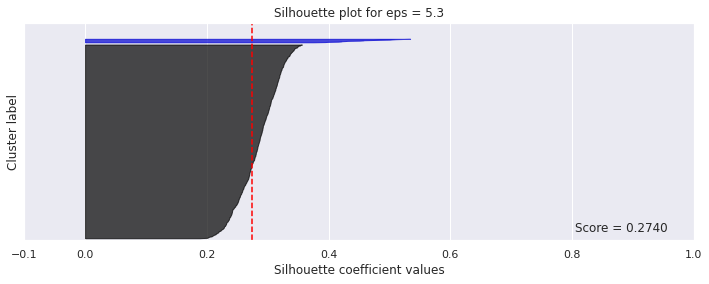

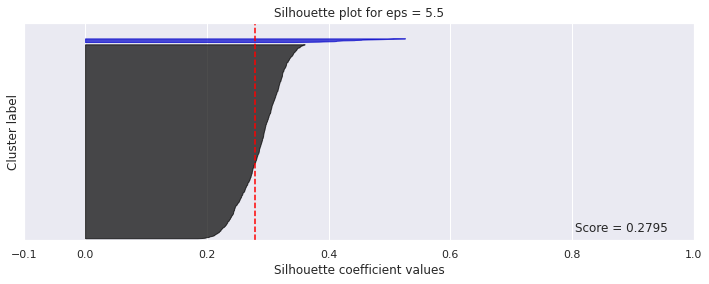

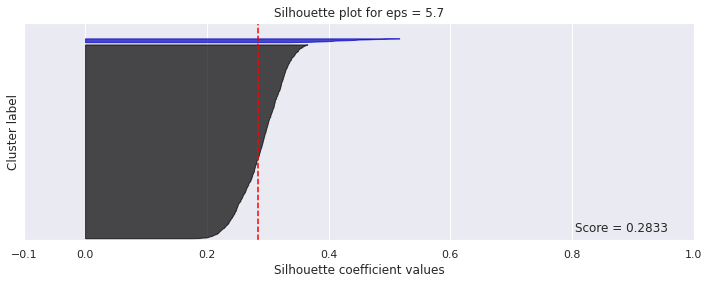

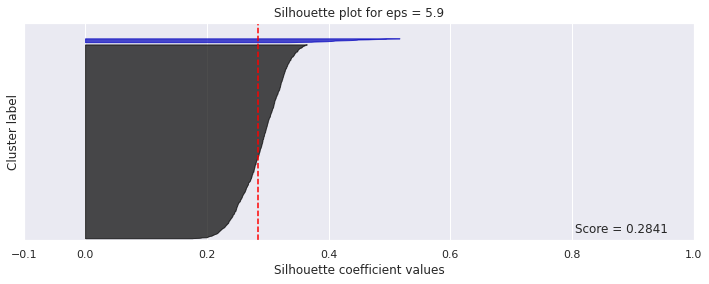

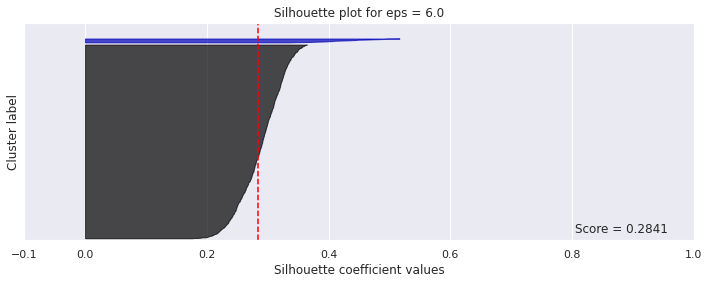

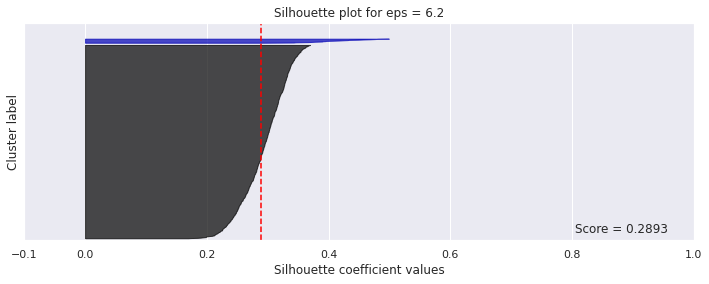

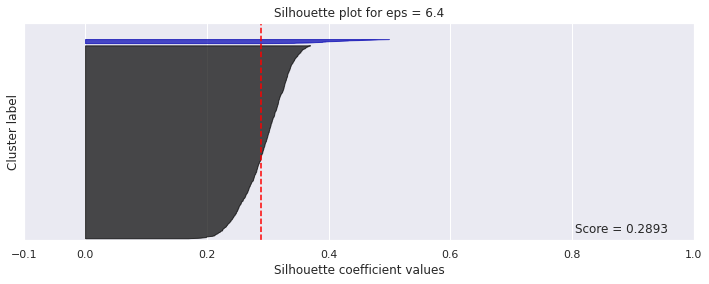

Max silhuette score is 0.2893 for eps = 6.2

Let's find the number of clusters with max value of min Silhuette score,  
    i.e. with minimum overlap.



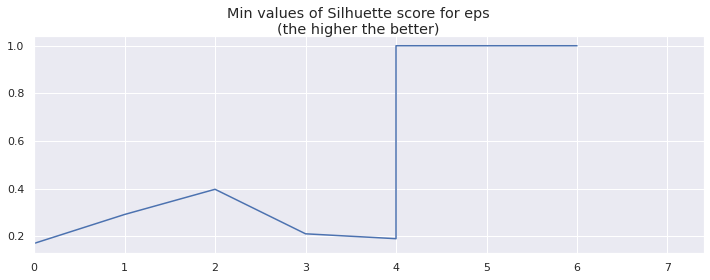

Best keys with max values of min silhuette scores : [4.2, 4.4, 4.6]


In [33]:
pp = {"min": 4.2, "max": 6.4, "steps": 13, "min_samples": 15}
silhuette_study(model=DBSCAN, **pp)

DBSCAN gives only 2 to 5 clusters with the best score for 2. Surprise!

### Agglomerative clustering

#### Iterate through linkage methods and distance thresholds

In [34]:
clusters = pd.DataFrame()
max_length = 1
ll = {1: "ward", 2: "single", 3: "complete", 4: "average"}
dist_thresh = np.linspace(3, 20, 18)
full_tree = True
for i in ll.keys():
    for j, dist in enumerate(dist_thresh):
        k = i*len(dist_thresh) + j
        clustering = AgglomerativeClustering(n_clusters=None, linkage=ll[i],
                                             compute_full_tree=full_tree, distance_threshold=dist).fit(X.values)
        labels = clustering.labels_
        unique, counts = np.unique(labels, return_counts=True)
        if len(unique) > max_length:
            max_length = len(unique)
        clusters = pd.concat([clusters, pd.Series(counts)],
                             axis=1)
clusters = clusters.fillna(0).astype("int")
clusters.index = list(range(max_length))
clusters.rename_axis(index=["cluster"], inplace=True)
clusters.columns = list(range(0, len(ll)*len(dist_thresh)))
clusters.rename(columns=lambda k: ll[k//len(dist_thresh)+1] +
                ", " + str(dist_thresh[k % len(dist_thresh)]), inplace=True)
clusters.rename_axis(columns=["linkage, dist_thresh"], inplace=True)
clusters = clusters.applymap((lambda x: "" if x == 0 else x))
counts = clusters.apply(lambda x: x.apply(type).value_counts()).iloc[0]

Show only the results with a reasonable number of clusters and minimum cluster size.  
Also remove results with only one cluster.

In [35]:
def min_nonzero(x):
    sort_x = sorted(x)
    sort_x = [x for x in sort_x if x != 0]
    return sort_x[0]


max_clusters = 20
min_cluster_size = 10

clusters = clusters.loc[:, counts < max_clusters]
clusters = clusters.applymap((lambda x: 0 if x == "" else x))
clusters = clusters.loc[:, clusters.apply(min_nonzero) >= min_cluster_size]
clusters = clusters.loc[:, clusters.loc[0, :] < 1000]
clusters = clusters.applymap((lambda x: "" if x == 0 else x))
clusters.iloc[:max_clusters]

linkage, dist_thresh ward, 20.0 single, 7.0 single, 8.0 single, 9.0  \
cluster                                                               
0                            85          22         976         988   
1                            97          12          12          12   
2                            88          12          12               
3                            71         954                           
4                            53                                       
5                            62                                       
6                            81                                       
7                            57                                       
8                            71                                       
9                            12                                       
10                           55                                       
11                           12                                       
12                           22                                       
13                           46                                       
14                           78                                       
15                           43                                       
16                           22                                       
17                           45                                       
18                                                                    
19                                                                    

linkage, dist_thresh complete, 9.0 complete, 10.0 complete, 11.0  \
cluster                                                            
0                              349            389            519   
1                               54            329            435   
2                               56             46             12   
3                               36             80             12   
4                               22             22             22   
5                              138             12                  
6                              124             56                  
7                               12             12                  
8                               66             54                  
9                               40                                 
10                              67                                 
11                              12                                 
12                              14                                 
13                              10                                 
14                                                                 
15                                                                 
16                                                                 
17                                                                 
18                                                                 
19                                                                 

linkage, dist_thresh complete, 12.0 complete, 13.0 complete, 14.0  \
cluster                                                             
0                               954            976            988   
1                                22             12             12   
2                                12             12                  
3                                12                                 
4                                                                   
5                                                                   
6                                                                   
7                                                                   
8                                                                   
9                                                                   
10                                                                  
11                                         

#### Dendrograms for AC

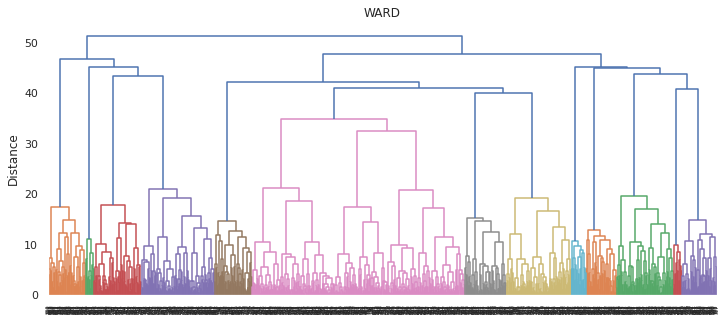

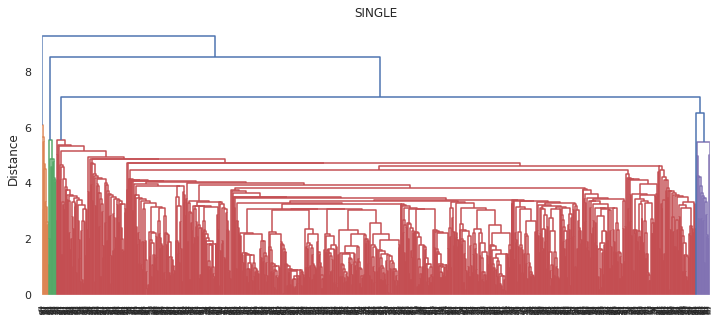

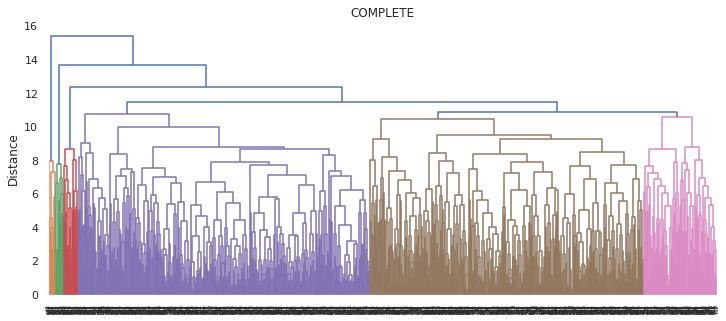

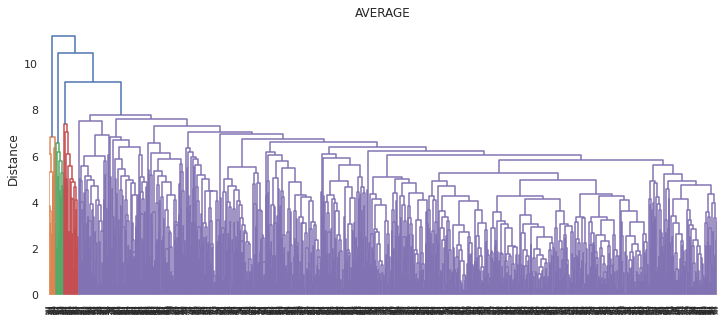

In [36]:
for i, linkage in enumerate(ll.values()):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f"{str.upper(linkage)}", loc="center")
    ax.set_ylabel("Distance")
    ax = shc.dendrogram(shc.linkage(X.values, method=linkage))
plt.show()

#### Run Silhuette study on AC

100%|██████████| 190/190 [00:04<00:00, 41.25it/s]


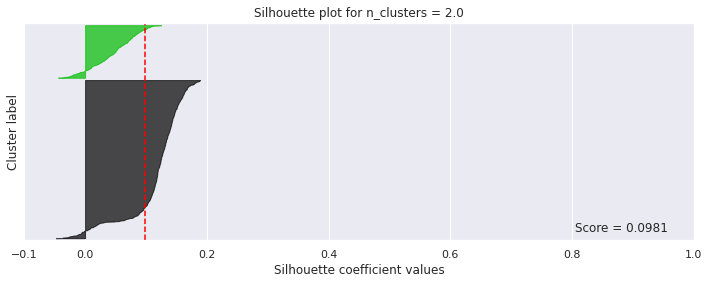

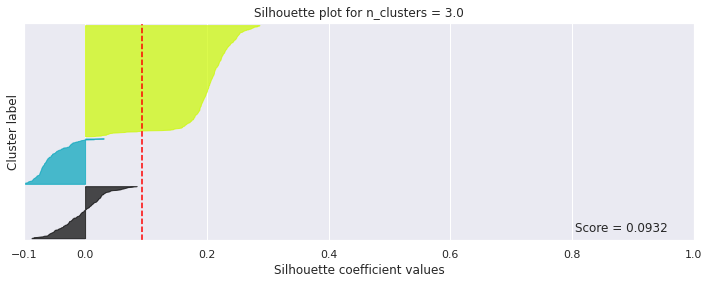

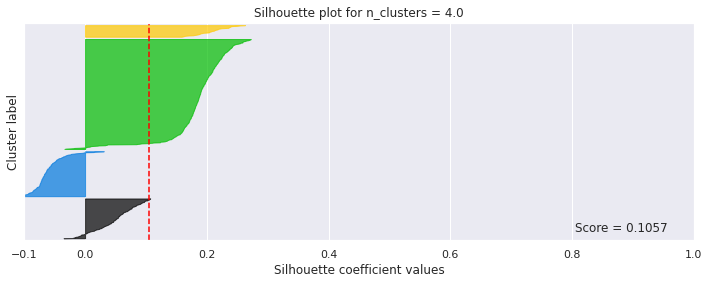

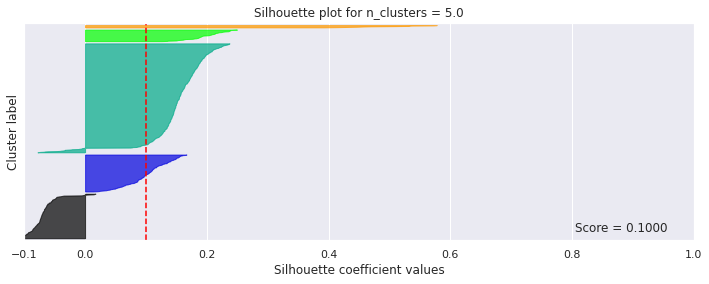

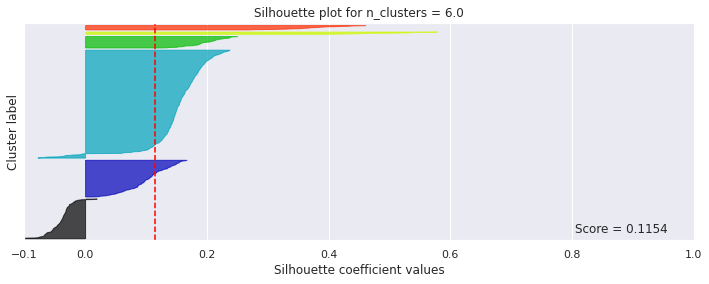

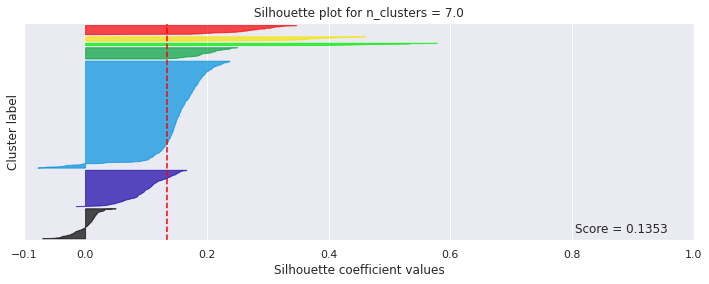

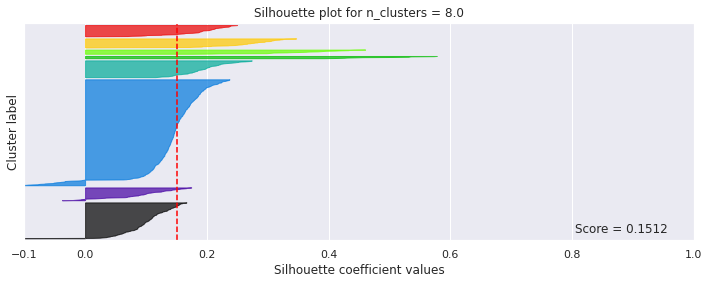

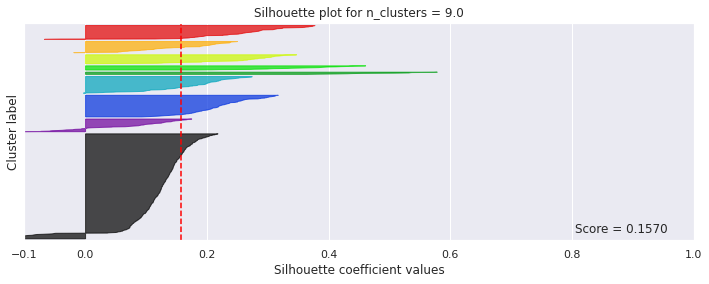

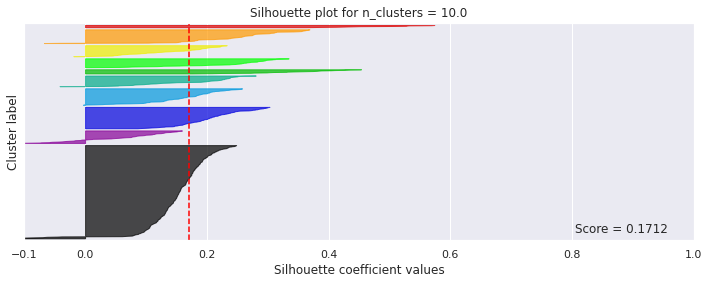

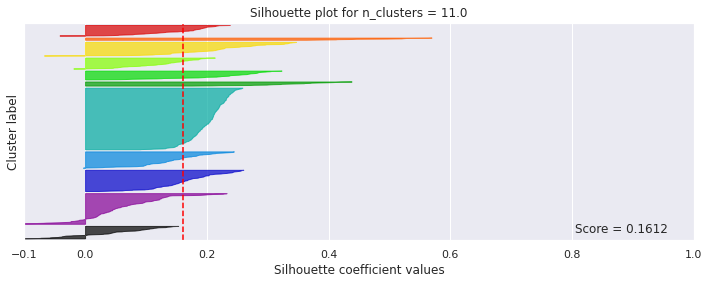

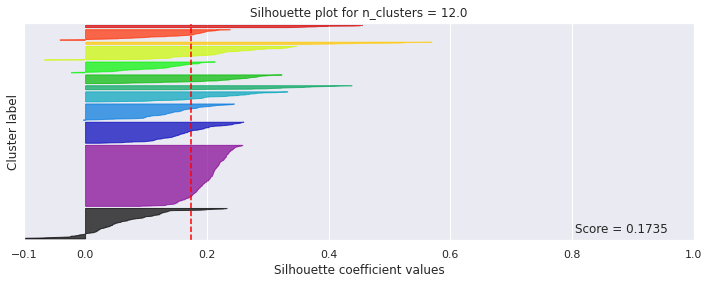

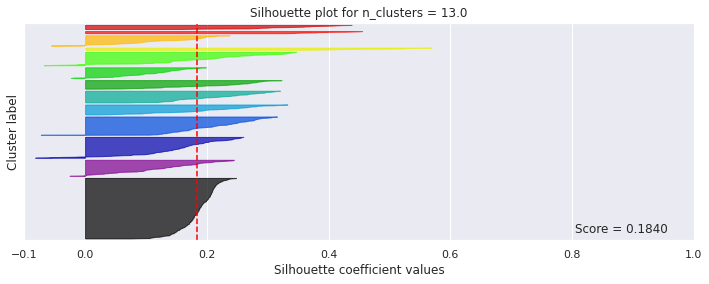

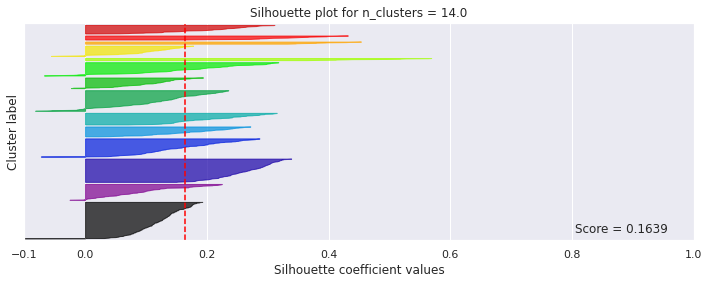

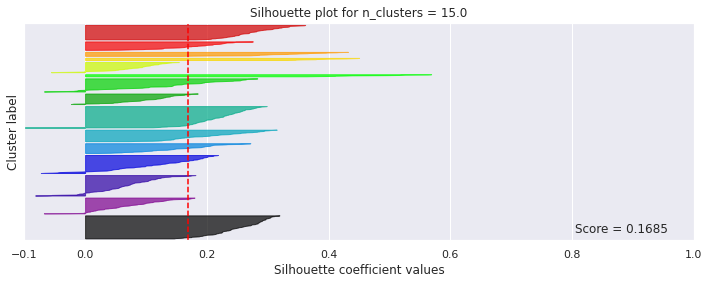

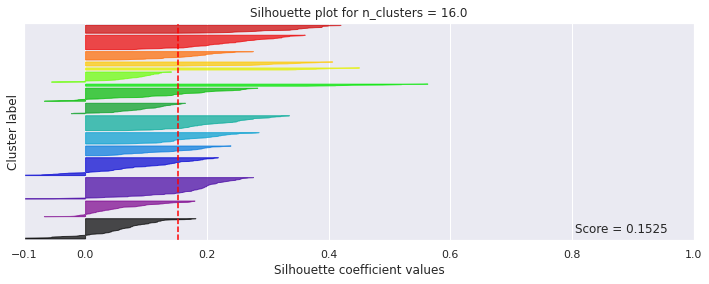

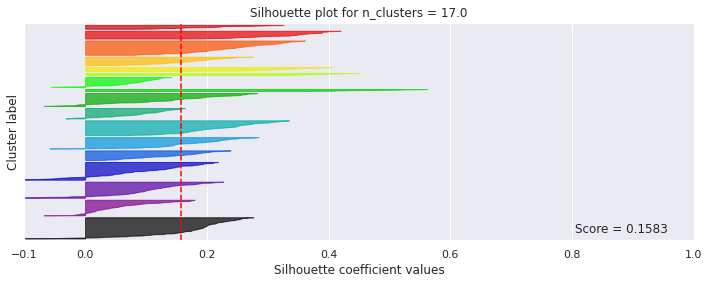

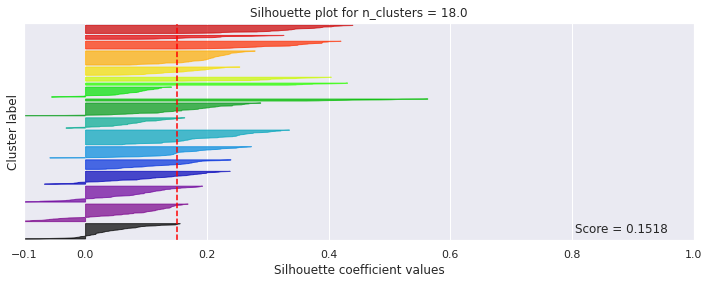

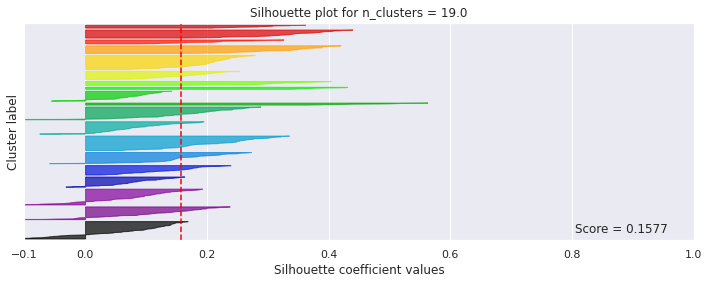

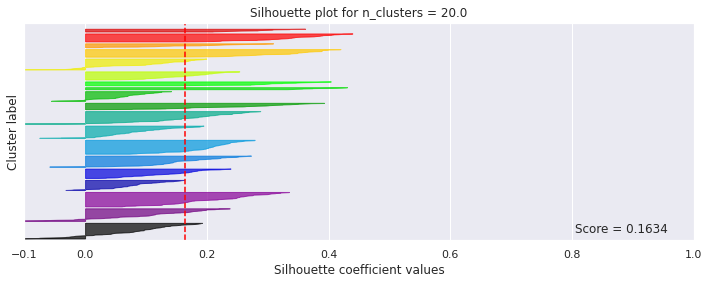

Max silhuette score is 0.1840 for n_clusters = 13.0

Let's find the number of clusters with max value of min Silhuette score,  
    i.e. with minimum overlap.



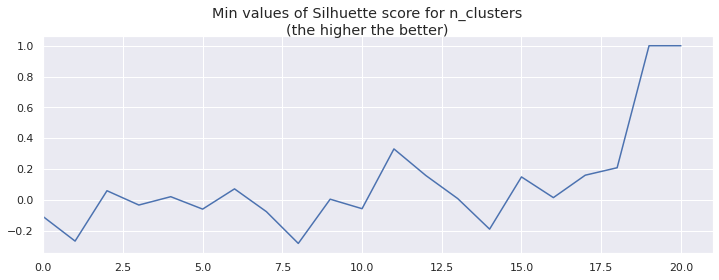

Best keys with max values of min silhuette scores : [19.0, 20.0, 11.0]


In [37]:
# Linkage methods: ward, complete, average, single
pp = {"min": 2, "max": 20, "steps": 19, "linkage": "ward"}
silhuette_study(model=AgglomerativeClustering, **pp)

``` 
Linkage      Clusters      Score
_________________________________
Average:            2      0.4043
Complete:           2      0.4043
Single:             2      0.4043
Ward:              13      0.1840


No clear winner. Ward with 13 clusters and Silhuette score of 0.1840 loses. Too bad(

### Dimensionality reduction - PCA, UMAP, T-SNE

In [38]:
def dim_reduction(X, dim_reduction=PCA(), n_clusters=4):

    # Before:
    kmeans = KMeans(n_clusters, random_state=random_state)
    X_clust = kmeans.fit_transform(X)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].scatter(X_clust[:, 0], X_clust[:, 1], s=20,
                  c=kmeans.labels_.astype(float), cmap="coolwarm")
    ax[0].set_xlabel("X0")
    ax[0].set_ylabel("X1")

    # After
    X_transf = dim_reduction.fit_transform(X_clust)
    ax[1].scatter(X_transf[:, 0], X_transf[:, 1], s=20,
                  c=kmeans.labels_.astype(float), cmap="coolwarm")
    p = re.compile("^[^\(]*")

    plt.suptitle(
        f"""Scatterplot of the first two features (X0, X1)
           in {n_clusters} clusters before and after {p.search(str(dim_reduction)).group()}""")
    ax[1].set_xlabel("X0")
    ax[1].set_ylabel("X1")
    plt.show()

#### Clusters before and after PCA

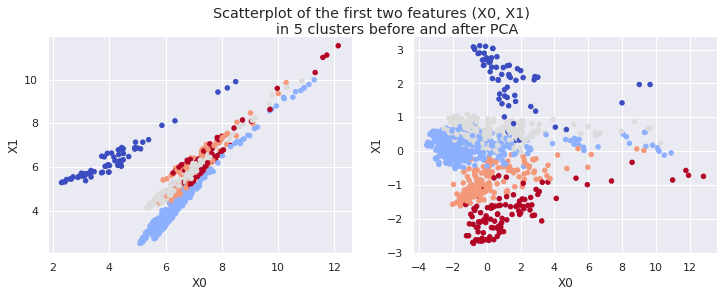

In [39]:
dim_reduction(X, PCA(), n_clusters=5)

The clusters are better separated, although not ideally, after PCA procedure. We can observe transformation of purely ribbon clusters to a ribbon/blob mixture.

###  TSNE and UMAP

#### TSNE transform

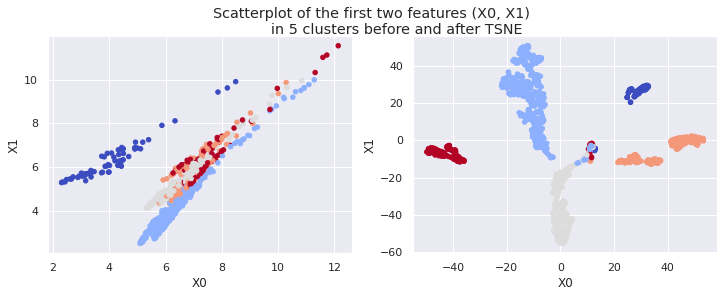

In [40]:
dim_reduction(X.values, TSNE(), n_clusters=5)

Separation after TSNE is somewhat more pronounced, but still not ideal.

#### UMAP transform

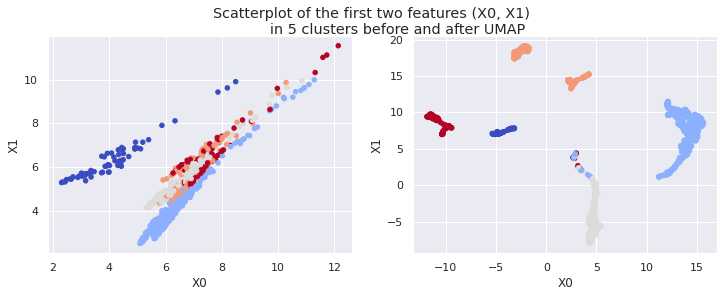

In [41]:
dim_reduction(X, UMAP(), n_clusters=5)

Here UMAP achieves the best separation of clusters.

#### Let's play a bit more, and try 3D with the full set of features

In [42]:
def visualize(model, **p):
    mdl = model(**p)
    X_clust = mdl.fit(X)
    X_color = X_clust.labels_.astype(str)
    features = X.values
    n_features = features.shape[1]

    # PCA
    pca = PCA()
    projections = pca.fit_transform(features)

    fig = px.scatter(
        projections, x=0, y=1,
        color=X_color, labels={'color': 'clusters'},
        title=f"PCA projection",
        width=720, height=480,
        template="plotly_dark")
    fig.show()

    # TSNE
    tsne2d = TSNE(n_components=2, random_state=random_state)
    tsne3d = TSNE(n_components=3, random_state=random_state)

    proj2d = tsne2d.fit_transform(features)
    proj3d = tsne3d.fit_transform(features)

    fig2t = px.scatter(
        proj2d, x=0, y=1,
        color=X_color, labels={'color': 'cluster'},
        title=f"TSNE-2d projection",
        width=720, height=480,
        template="plotly_dark"
    )
    fig2t.show()

    fig3t = px.scatter_3d(
        proj3d, x=0, y=1, z=2,
        color=X_color, labels={'color': 'cluster'},
        title=f"TSNE-3d projection",
        width=720, height=480,
        template="plotly_dark"
    )
    fig3t.update_traces(marker_size=8)
    fig3t.show()

    # UMAP
    umap_2d = UMAP(n_components=2, init='random',
                   random_state=random_state)
    umap_3d = UMAP(n_components=3, init='random',
                   random_state=random_state)

    proj_2d = umap_2d.fit_transform(features)
    proj_3d = umap_3d.fit_transform(features)

    fig_2d = px.scatter(
        proj_2d, x=0, y=1,
        color=X_color, labels={'color': 'clusters'},
        title=f"UMAP-2d projection",
        width=720, height=480,
        template="plotly_dark"
    )
    fig_2d.show()

    fig_3d = px.scatter_3d(
        proj_3d, x=0, y=1, z=2,
        color=X_color, labels={'color': 'clusters'},
        title=f"UMAP-3d projection",
        width=720, height=480,
        template="plotly_dark"
    )
    fig_3d.update_traces(marker_size=5)
    fig_3d.show()

    cln, cl_size = np.unique(X_color, return_counts=True)
    clusters = pd.DataFrame(cl_size, index=cln).T.rename(
        index=({0: "Cluster size"}))
    clusters.rename_axis(columns=["Cluster #"], inplace=True)
    return(clusters)

##### Visualize for KMeans

In [43]:
pp = {"n_clusters": 5, "random_state": random_state}
visualize(KMeans, **pp)

Cluster #      0    1    2    3    4
Cluster size  63  430  238  167  102

##### Visualize for DBSCAN

In [44]:
pp = {"eps": 4.5, "min_samples": 20}
visualize(DBSCAN, **pp)

Cluster #      -1   0    1   2   3
Cluster size  117  45  783  33  22

### Features in clusters (DBSCAN)

#### Features' means by cluster

Let's choose a case with a smallish number of clusters to make our comparisons easier.

In [45]:
db = DBSCAN(eps=4.5, min_samples=20)
X_clust = db.fit(X)
X_color = X_clust.labels_

cln, cl_size = np.unique(X_color, return_counts=True)
clusters = pd.DataFrame(cl_size, index=cln).T.rename(
    index=({0: "Cluster size"}))
clusters.rename_axis(columns=["Cluster #"], inplace=True)
clusters

Cluster #      -1   0    1   2   3
Cluster size  117  45  783  33  22

In [46]:
means = X.groupby(X_color).mean()
means.rename_axis(index="Cluster", inplace=True)
means

Age     Sex     Job  Housing_own  Housing_rent  Housing_free  \
Cluster                                                                    
-1      -0.1414  0.0992  0.2323      -0.1239       -0.4280        0.1399   
 0      -0.2196  0.1471 -0.2883       0.0538        0.3010       -0.1331   
 1       0.0483 -0.0372 -0.0268       0.0126        0.0310       -0.0094   
 2      -0.1403  0.1234  0.1131      -0.1319        0.4431       -0.2423   
 3      -0.5936  0.6089  0.0150      -0.1384        0.4431       -0.4764   

         Saving accounts_quite rich  Saving accounts_moderate  \
Cluster                                                         
-1                           0.4532                    0.3774   
 0                          -0.2753                    3.8730   
 1                          -0.0337                   -0.2582   
 2                          -0.3471                   -0.2582   
 3                          -0.0536                   -0.2582   

         Saving accounts_little  Saving accounts_unknown  \
Cluster                                                    
-1                       0.1267                  -0.3535   
 0                      -0.3448                  -1.2058   
 1                       0.0116                   0.1925   
 2                      -0.3448                  -1.2058   
 3                      -0.3448                   0.2743   

         Saving accounts_rich  Checking account_unknown  \
Cluster                                                   
-1                    -0.0951                    0.3794   
 0                    -0.4863                   -0.2233   
 1                     0.0300                   -0.2233   
 2                    -0.4863                    4.4780   
 3                     0.2072                   -0.2233   

         Checking account_rich  Checking account_little  \
Cluster                                                   
-1                     -0.3209                   0.3701   
 0                      0.5529                  -0.2717   
 1                     -0.0294                  -0.0496   
 2                      0.6148                  -0.2717   
 3                      0.4909                  -0.2717   

         Checking account_moderate  Credit amount  Duration  Purpose_radio/TV  \
Cluster                                                                         
-1                         -0.0689         0.2157    0.0209           -0.5031   
 0                         -0.3243        -0.1288   -0.0606            0.4259   
 1                          0.0363         0.0244    0.0110            0.0848   
 2                         -0.3513        -0.1705   -0.0692           -0.1434   
 3                         -0.2162        -0.1705   -0.4246           -0.6178   

         Purpose_car  Purpose_furniture/equipment  Purpose_business  \
Cluster                                                               
-1           -0.5214                      -0.2512           -0.1164   
 0           -0.2042                       0.0453           -0.0167   
 1            0.0857                       0.0367            0.0464   
 2            0.3029                       0.1551           -0.1137   
 3           -0.7197                      -0.4725           -0.3216   

         Purpose_education  Purpose_vacation/others  \
Cluster                                               
-1                  1.1284                   0.8106   
 0                 -0.2441                  -0.1125   
 1                 -0.2441                  -0.1125   
 2                 -0.2441                  -0.1125   
 3                  4.0961                  -0.1125   

         Purpose_domestic appliances  Purpose_repairs  
Cluster                                                
-1                            0.7204           1.1162  
 0                           -0.1234          -0.1517  
 1                           -0.1234          -0.1517  
 2                           -0.1234      

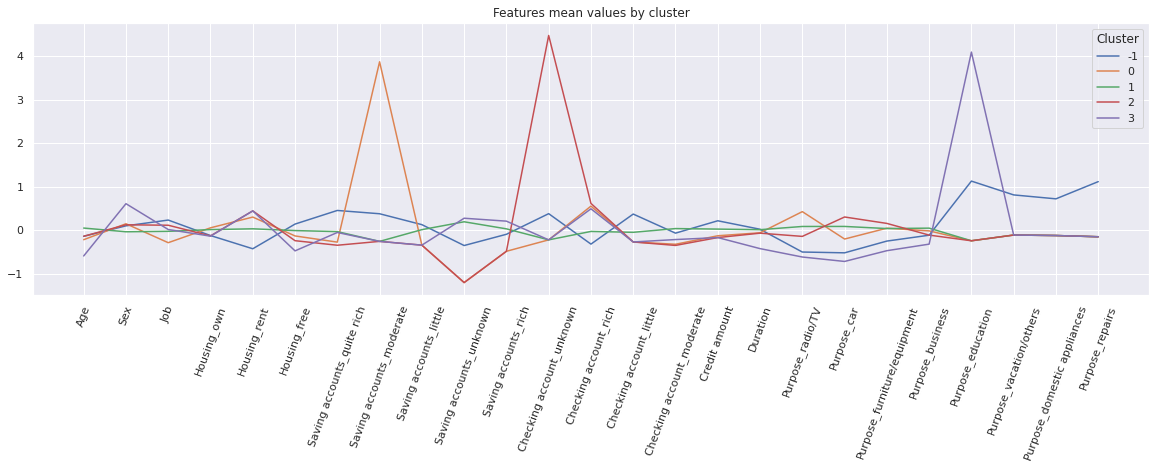

In [47]:
fig, ax = plt.subplots(figsize=(20,5))
means.T.plot(rot=70, title="Features mean values by cluster",
             ax=ax) 
ax.set_xticks(np.arange(len(means.columns)))
ax.set_xticklabels(means.columns)
plt.show()

We can see that the most populous cluster 1 has much smaller variations around 0 than the smaller ones: -1, 0, 2, and 3.  
Positions of maxima of features vary significantly from one cluster to another. 

#### Features' medians by cluster

In [48]:
medians = X.groupby(X_color).median()
medians.rename_axis(index="Cluster", inplace=True)
medians

Age     Sex     Job  Housing_own  Housing_rent  Housing_free  \
Cluster                                                                    
-1      -0.2724  0.2138 -0.6722       0.0709         0.643       -0.4764   
 0       0.0147  0.3099 -0.6722       0.0709         0.643       -0.4764   
 1       0.0272  0.0033 -0.6722       0.0709         0.643       -0.4764   
 2      -0.1160  0.1115 -0.6722       0.0709         0.643       -0.4764   
 3      -0.5806  0.5221 -0.6722       0.0709         0.643       -0.4764   

         Saving accounts_quite rich  Saving accounts_moderate  \
Cluster                                                         
-1                          -0.3471                   -0.2582   
 0                          -0.3471                    3.8730   
 1                          -0.3471                   -0.2582   
 2                          -0.3471                   -0.2582   
 3                          -0.3471                   -0.2582   

         Saving accounts_little  Saving accounts_unknown  \
Cluster                                                    
-1                      -0.3448                  -1.2058   
 0                      -0.3448                  -1.2058   
 1                      -0.3448                   0.8293   
 2                      -0.3448                  -1.2058   
 3                      -0.3448                   0.8293   

         Saving accounts_rich  Checking account_unknown  \
Cluster                                                   
-1                    -0.4863                   -0.2233   
 0                    -0.4863                   -0.2233   
 1                    -0.4863                   -0.2233   
 2                    -0.4863                    4.4780   
 3                    -0.4863                   -0.2233   

         Checking account_rich  Checking account_little  \
Cluster                                                   
-1                     -0.8101                  -0.2717   
 0                      1.2344                  -0.2717   
 1                     -0.8101                  -0.2717   
 2                      1.2344                  -0.2717   
 3                      1.2344                  -0.2717   

         Checking account_moderate  Credit amount  Duration  Purpose_radio/TV  \
Cluster                                                                         
-1                         -0.6217         -0.587   -0.0316           -0.6178   
 0                         -0.6217         -0.587   -0.0316           -0.6178   
 1                         -0.6217         -0.587   -0.0316           -0.6178   
 2                         -0.6217         -0.587   -0.0316           -0.6178   
 3                         -0.6217         -0.587   -0.7699           -0.6178   

         Purpose_car  Purpose_furniture/equipment  Purpose_business  \
Cluster                                                               
-1           -0.7197                      -0.4725           -0.3216   
 0           -0.7197                      -0.4725           -0.3216   
 1           -0.7197                      -0.4725           -0.3216   
 2           -0.7197                      -0.4725           -0.3216   
 3           -0.7197                      -0.4725           -0.3216   

         Purpose_education  Purpose_vacation/others  \
Cluster                                               
-1                 -0.2441                  -0.1125   
 0                 -0.2441                  -0.1125   
 1                 -0.2441                  -0.1125   
 2                 -0.2441                  -0.1125   
 3                  4.0961                  -0.1125   

         Purpose_domestic appliances  Purpose_repairs  
Cluster                                                
-1                           -0.1234          -0.1517  
 0                           -0.1234          -0.1517  
 1                           -0.1234          -0.1517  
 2                           -0.1234      

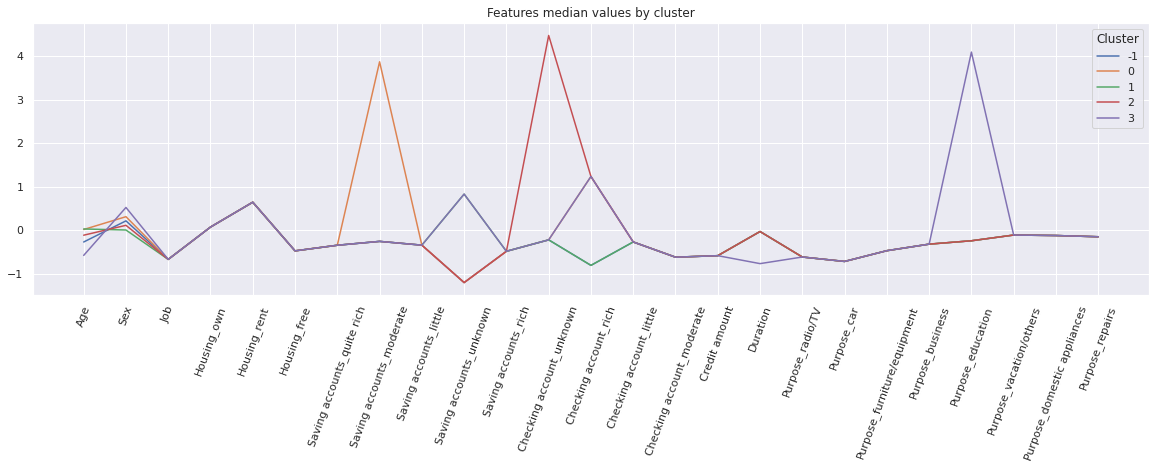

In [49]:
fig, ax = plt.subplots(figsize=(20,5))
medians.T.plot(rot=70, title="Features median values by cluster",
             ax=ax) 
ax.set_xticks(np.arange(len(medians.columns)))
ax.set_xticklabels(medians.columns)
plt.show()

Medians give a good picture of clients' profiles by cluster. Let's do some boxplots of features distributions by cluster.

#### Boxplots of features by cluster

Print out columns names for convenience

In [50]:
for i, c in enumerate(X.columns):
    print(f"{i:4} {c}")

   0 Age
   1 Sex
   2 Job
   3 Housing_own
   4 Housing_rent
   5 Housing_free
   6 Saving accounts_quite rich
   7 Saving accounts_moderate
   8 Saving accounts_little
   9 Saving accounts_unknown
  10 Saving accounts_rich
  11 Checking account_unknown
  12 Checking account_rich
  13 Checking account_little
  14 Checking account_moderate
  15 Credit amount
  16 Duration
  17 Purpose_radio/TV
  18 Purpose_car
  19 Purpose_furniture/equipment
  20 Purpose_business
  21 Purpose_education
  22 Purpose_vacation/others
  23 Purpose_domestic appliances
  24 Purpose_repairs


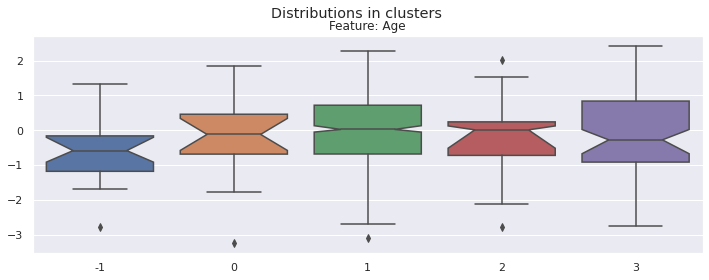

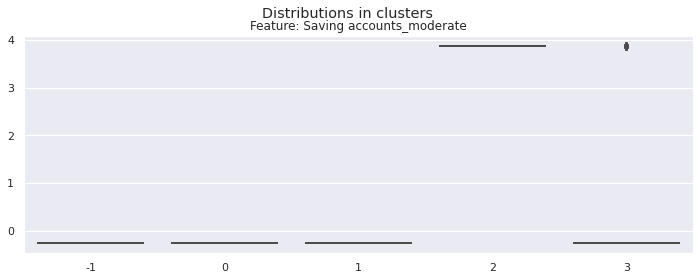

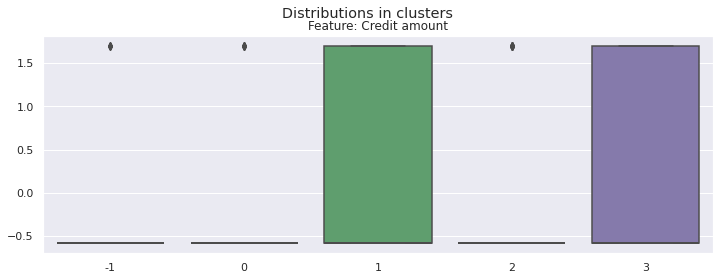

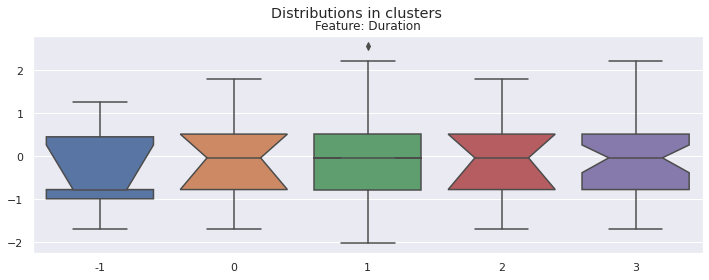

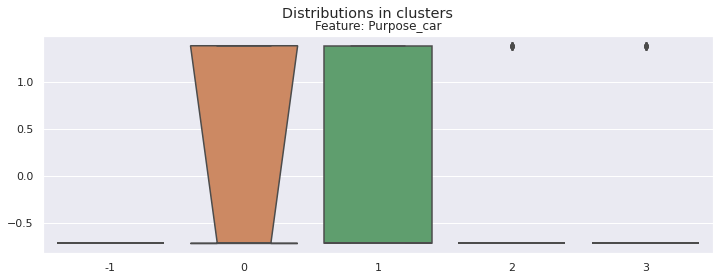

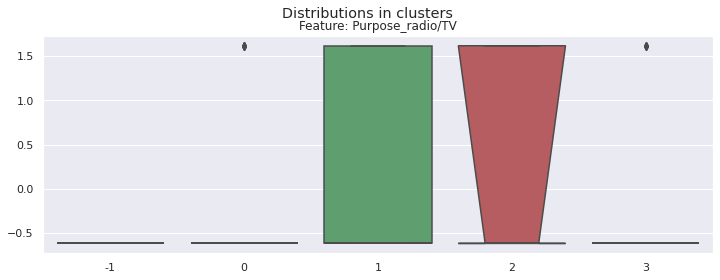

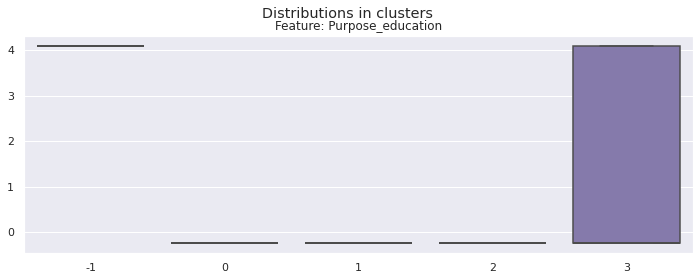

In [51]:
fig, ax = plt.subplots() 
for i, f in enumerate(X.columns[[0, 7, 15, 16, 18, 17, 21]]):

    X_f = X.loc[np.where(X_color == np.unique(X_color)[0]), f]
    for cl in np.unique(X_color)[1:]: 
        X_f = pd.concat([X.loc[np.where(X_color == cl), f],
                        X_f], join="outer", ignore_index=True, axis=1)
    X_f = X_f[~np.isnan(X_f)]
    X_f.columns = range(-1, 4)
    cln, cl_size = np.unique(X_clust.labels_, return_counts=True)
    ax = sns.boxplot(data=X_f, notch=True, bootstrap=500)
    ax.set_title(f"Feature: {f}")
    plt.suptitle(
        f"Distributions in clusters")
    plt.show()

Well, these plots do not add much information, mostly because of outliers. Let's try violin plots.

### Who is who: distribution of features by cluster

Let's use the above clusters and explore their composition. 

In [52]:
clusters = X.groupby(X_clust.labels_)
colors = ["b","g","orange","r","purple"]
print("Clusters' sizes:\n")
for i, cluster in enumerate(clusters):
    print(f"\t{i-1:3}: {cluster[1].shape[0]:5}")

Clusters' sizes:

	 -1:   117
	  0:    45
	  1:   783
	  2:    33
	  3:    22


Violin plots: features by cluster

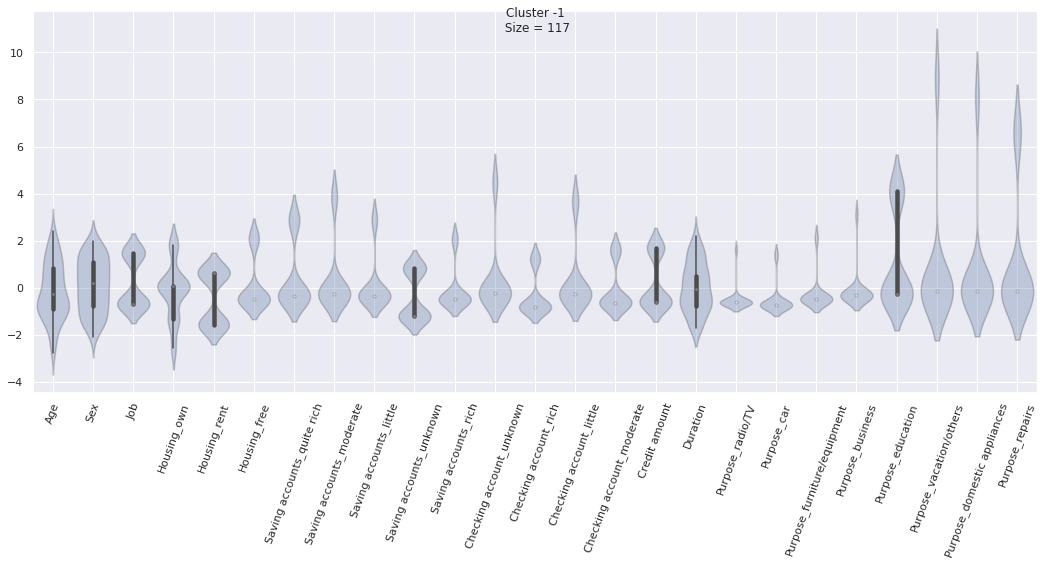

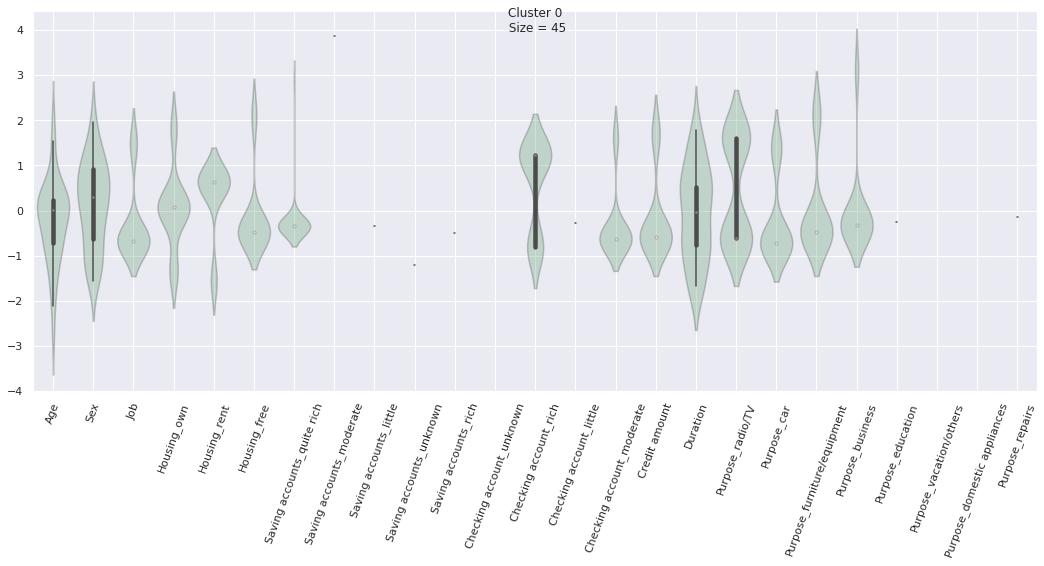

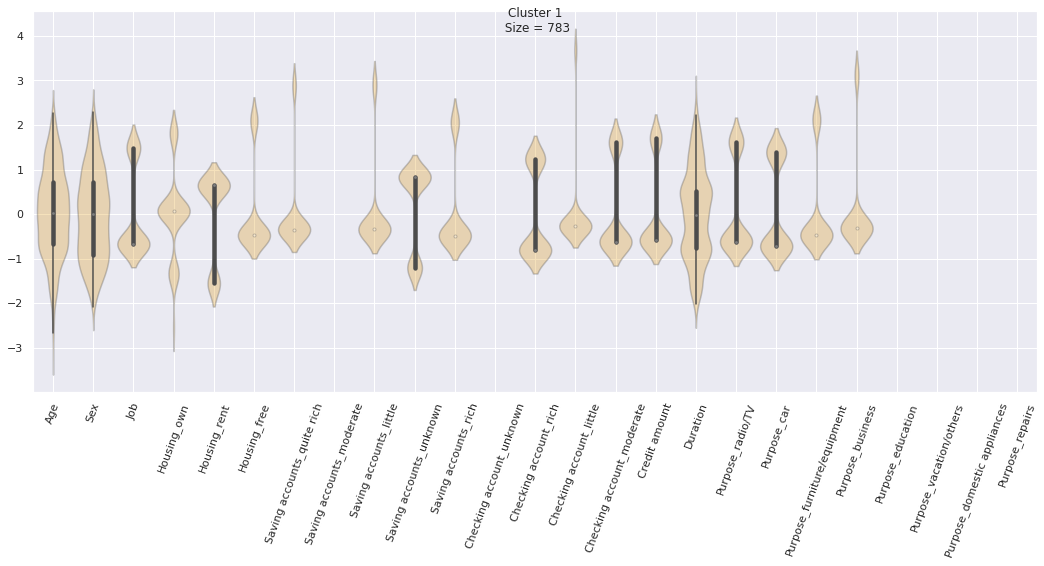

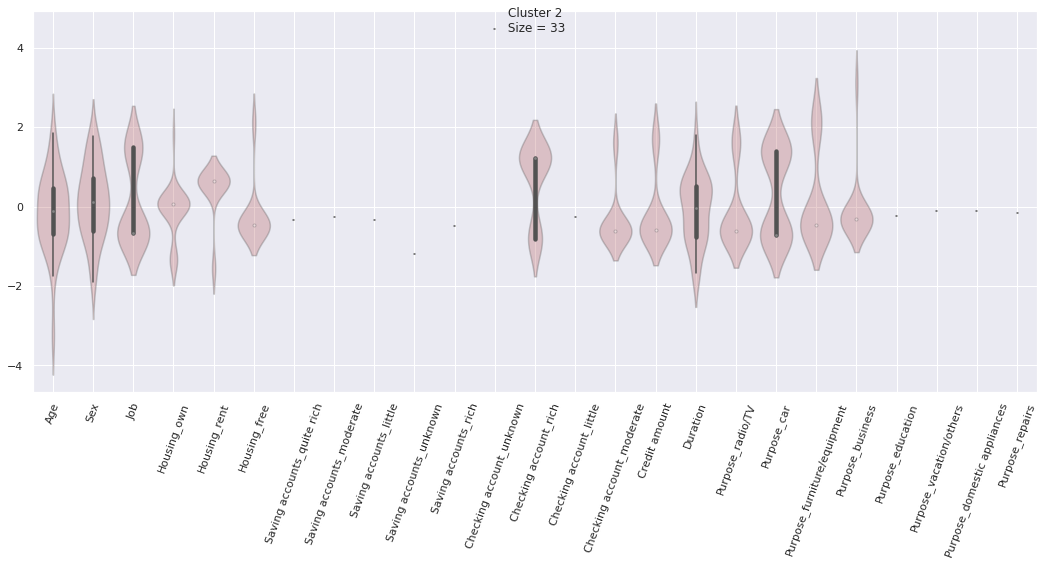

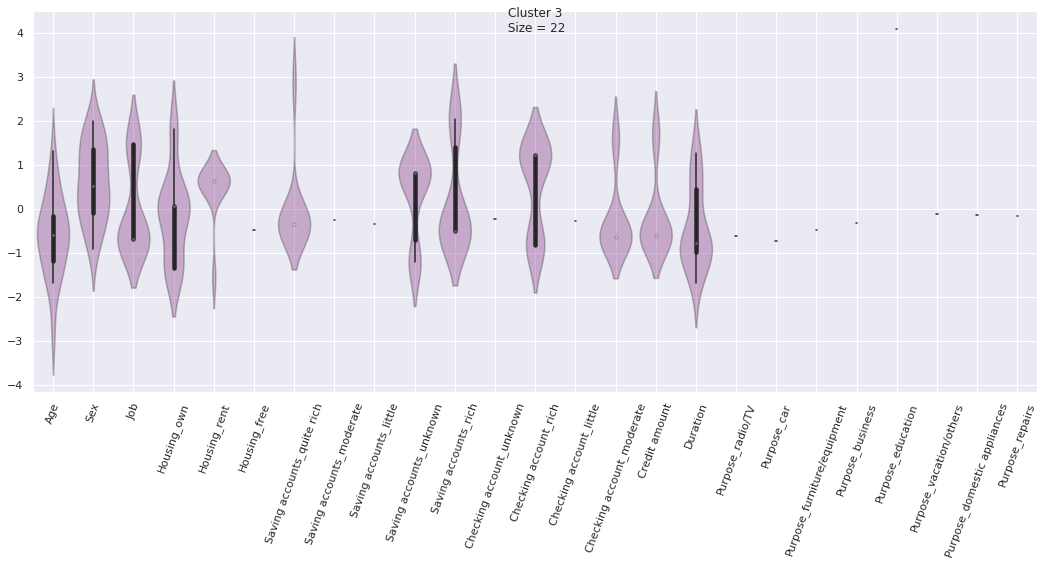

In [53]:
for i, cluster in enumerate(clusters):
    fig, ax = plt.subplots(figsize=(18,7))
    sns.violinplot(rot=70, data=cluster[1], scale="count",color=colors[i],ax = ax)
    cluster_size = cluster[1].shape[0]
    ax.set_title(f"Cluster {i-1}\n Size = {cluster_size}", y=0.93)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.tick_params(axis='x', labelrotation=70)
    plt.setp(ax.collections, alpha=.3)
    plt.show()

Violin plots: features by cluster superimposed

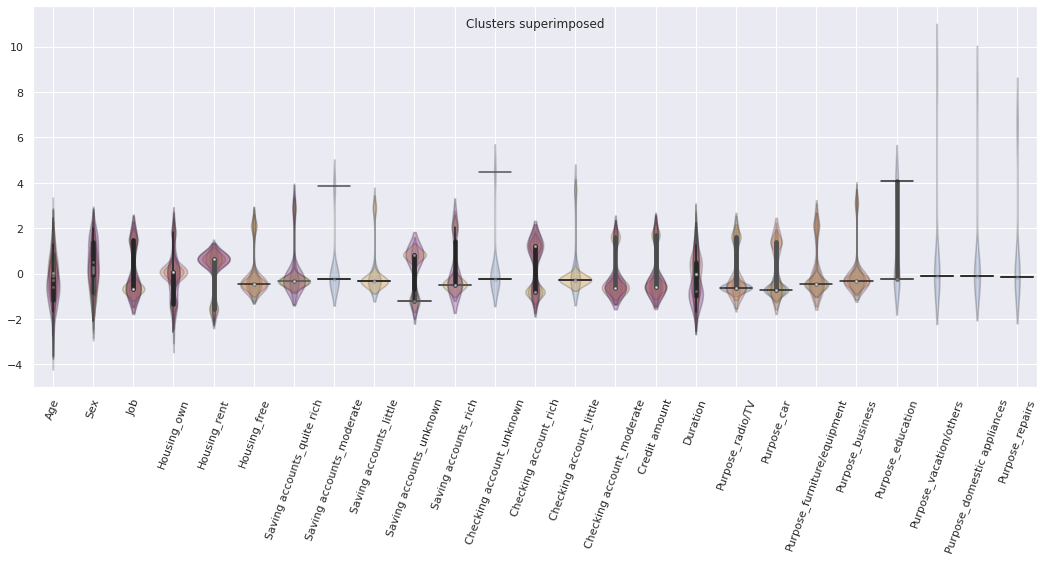

In [54]:
fig, ax = plt.subplots(figsize=(18,7))

for i, cluster in enumerate(clusters):
    sns.violinplot(rot=70,data=cluster[1],color=colors[i], alpha=.2, ax = ax)
    plt.setp(ax.collections, alpha=.3)
    ax.set_title(f"Clusters superimposed", y=0.93)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.tick_params(axis='x', labelrotation=70)
plt.show()

Violin plots seem to be an ideal vizualisation instrument in this case.

### Conclusions

Cluster -1:  
By design, this class consists of "outliers" that failed to get into any regular DBSCAN cluster. Hence, its composition is quite diverse.  Customers with unkonown, little and moderate wealth features prevail. 
Significant share of edicuational loans may indicate that students are a significant part.
It is the only cluster where shorter-term credit goals like vacations, domestic appliances and repairs are represented at all. Altogether the evidence supports naming this cluster "poorer people".

Cluster 0:  
Cars, equipment and business credit purposes together with sizable checking accounts indicate a "better off" group of customers. 
Note, however, that they lack savings. Lower-level managers and high-skilled workers fit well.

Cluster 1:  
The most populous group. Shorter loan periods with prevalence in longer-term purposes. Structure of plot shows that this cluster should better be split into two to separate better and worse off memebers: we can obesrve almost identical number in "Saving accounts_quite rich", "Saving accounts_rich" and "Saving accounts_little" with nothing in the middle category.

Cluster 2:  
Small group of better off individuals borrowing mostly for longer terms with with somewhat shorter terms.

Claster 3:  
The smallest cluster - well off customers with elevated share of students as evidenced by a spike in "Purpose_education".

### Some reflections

Although a number of metrics and methods provide measures of "success" in clustering, they may give widly varying estimates. In case of non-trivial cluster topology the outcome may significantly depend on the choice of H/Ps. In practical applications it may we worthwile to use several clusterings to have more "stereoscopic" vision. The crucial observation is that the choice of method and its respective H/Ps must follow from the problem at hand. Do we need rough segmentation in 2-3 groups or a more fine-grained analysis is needed? What are we looking for? There is some good news too: relatively simple analysis of means and variations of features in clusters provides a way to interpret the results, making this approach less of a black box than some other ML algorithms.